# U-net 20x under-sampling

# This was done in  Google cloud, using V100 GPUs

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import cv2
import h5py

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.autograd import Variable

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Data preparation

Note that I had to deal with several data coming from different places in different formats. I used Jupyter notebook to prepare the data and then run the network also using the jupyter notebook.
I do a lot of permutes and traspose to turn the data into the format I want.

In [3]:
data_recon_1 = scipy.io.loadmat('data/resampledData_Training_20under_1to500.mat')
data_recon_2 = scipy.io.loadmat('data/resampledData_Training_20under_501to1200.mat')

data_truth_1 = data_recon_1['imagesTruth']
data_truth_2 = data_recon_2['imagesTruth']

data_resampled_1 = data_recon_1['imagesResampled']
data_resampled_2 = data_recon_2['imagesResampled']

data_truth = np.ndarray((128, 128, 20, 1200))
for k in range(500):
    data_truth[:,:,:,k] = data_truth_1[:,:,:,k]
for k in range(700):
    data_truth[:,:,:,k+500] = data_truth_2[:,:,:,k+500]
    
data_recon = np.ndarray((128, 128, 20, 1200))
for k in range(500):
    data_recon[:,:,:,k] = data_resampled_1[:,:,:,k]
for k in range(700):
    data_recon[:,:,:,k+500] = data_resampled_2[:,:,:,k+500]
    
del data_recon_1, data_recon_2, data_truth_1, data_truth_2, data_resampled_1, data_resampled_2

In [4]:
data_recon = data_recon.transpose()
data_truth = data_truth.transpose()
print(data_recon.shape)
print(data_truth.shape)

(1200, 20, 128, 128)
(1200, 20, 128, 128)


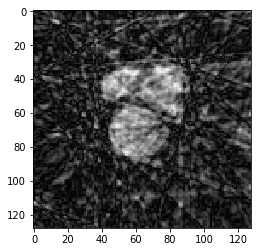

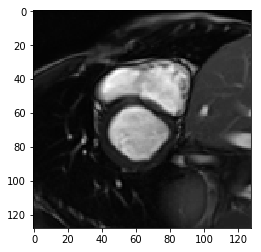

In [5]:
plt.imshow(data_recon[0,0,:,:], cmap='gray')
plt.show()
plt.imshow(data_truth[0,0,:,:], cmap='gray')
plt.show()

In [6]:
data_truth.shape

(1200, 20, 128, 128)

In [7]:
data_recon.shape

(1200, 20, 128, 128)

In [8]:
data_truth_channel = np.ndarray((1200,20,128,128,1))
data_recon_channel = np.ndarray((1200,20,128,128,1))

In [9]:
data_truth_channel[:,:,:,:,0] = data_truth
data_recon_channel[:,:,:,:,0] = data_recon
data_truth = data_truth_channel
data_recon = data_recon_channel

In [10]:
del data_truth_channel, data_recon_channel

In [11]:
print(data_recon.shape)
print(data_truth.shape)

(1200, 20, 128, 128, 1)
(1200, 20, 128, 128, 1)


In [12]:
data_recon = torch.from_numpy(data_recon)
data_truth = torch.from_numpy(data_truth)
data_recon = data_recon.float()
data_truth = data_truth.float()

In [13]:
print(data_recon.shape)
print(data_truth.shape)

torch.Size([1200, 20, 128, 128, 1])
torch.Size([1200, 20, 128, 128, 1])


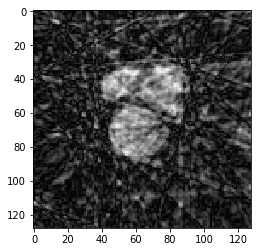

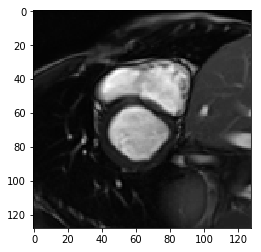

In [14]:
plt.imshow(data_recon[0,0,:,:,0], cmap='gray')
plt.show()
plt.imshow(data_truth[0,0,:,:,0], cmap='gray')
plt.show()

Test Data

In [15]:
data_test =scipy.io.loadmat('data/resampledData_Test_20.mat')
test_truth = data_test['imagesTruth']
test_recon = data_test['imagesResampled']
del data_test

In [16]:
print(test_truth.shape)
print(test_recon.shape)
test_truth = test_truth.transpose()
test_recon = test_recon.transpose()
print(test_truth.shape)
print(test_recon.shape)

(128, 128, 20, 222)
(128, 128, 20, 222)
(222, 20, 128, 128)
(222, 20, 128, 128)


In [17]:
data_truth_channel = np.ndarray((222,20,128,128,1))
data_recon_channel = np.ndarray((222,20,128,128,1))

In [18]:
data_truth_channel[:,:,:,:,0] = test_truth
data_recon_channel[:,:,:,:,0] = test_recon
test_truth = data_truth_channel
test_recon = data_recon_channel

In [19]:
del data_truth_channel, data_recon_channel

In [20]:
print(test_truth.shape)
print(test_recon.shape)

(222, 20, 128, 128, 1)
(222, 20, 128, 128, 1)


In [21]:
test_recon = torch.from_numpy(test_recon)
test_truth = torch.from_numpy(test_truth)
test_recon = test_recon.float()
test_truth = test_truth.float()

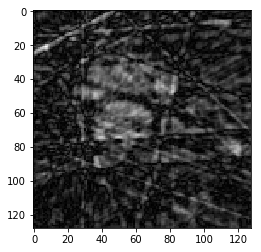

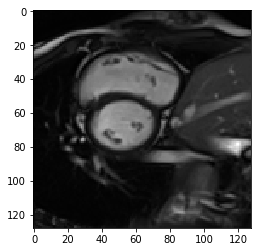

In [22]:
plt.imshow(test_recon[0,0,:,:,0], cmap='gray')
plt.show()
plt.imshow(test_truth[0,0,:,:,0], cmap='gray')
plt.show()

In [23]:
print(data_truth.shape)
print(data_recon.shape)
print(test_truth.shape)
print(test_recon.shape)


torch.Size([1200, 20, 128, 128, 1])
torch.Size([1200, 20, 128, 128, 1])
torch.Size([222, 20, 128, 128, 1])
torch.Size([222, 20, 128, 128, 1])


In [24]:
data_truth = data_truth.permute(0,4,2,3,1)
data_recon = data_recon.permute(0,4,2,3,1)
test_truth = test_truth.permute(0,4,2,3,1)
test_recon = test_recon.permute(0,4,2,3,1)

In [25]:
print(data_truth.shape)
print(data_recon.shape)
print(test_truth.shape)
print(test_recon.shape)



torch.Size([1200, 1, 128, 128, 20])
torch.Size([1200, 1, 128, 128, 20])
torch.Size([222, 1, 128, 128, 20])
torch.Size([222, 1, 128, 128, 20])


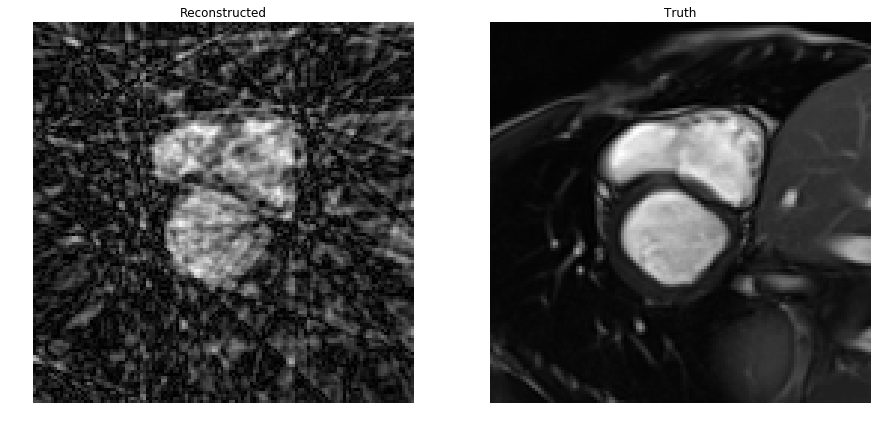

In [26]:
# Let's look at a smaple data again to check everything is the same
f, arr = plt.subplots(1,2,figsize=(15,15))
arr[0].imshow(data_recon[0,0,:,:,0], cmap='gray')
arr[0].set_title("Reconstructed")
arr[0].axis('off')
arr[1].imshow(data_truth[0,0,:,:,0], cmap='gray')
arr[1].set_title("Truth")
arr[1].axis('off');

# U-net model

In [27]:
class unet(nn.Module):
    """
    Implementation of the U-net as in the Hauptmann et al.
    --------------
    inputs = Aliased data, 4D tensor, shape: (N_batch, N_channels, depth, height, width)
    The order of the depth, height and width doesn't really matter.
    --------------
    outputs---> De-aliased data, 4D tensor, shape(N_batch, N_channels, depth, height, width)    
    """
    def __init__(self, input_channel=1, first_output_channel=32, kernel_size=3):
        super(unet, self).__init__()
        self.kernel_size = kernel_size
        # All the convolutions used. The subscript is the level going down until to 3
        # and then goes upwards 
        # convi_i is the same convolution as i repeated but differnet input channels

        self.conv1 = nn.Conv3d(input_channel, first_output_channel, kernel_size, padding=1)
        # Default: self.conv1 = nn.Conv3d(1, 32, kernel_size, padding=1)
        self.conv1_1 = nn.Conv3d(first_output_channel, first_output_channel, kernel_size, padding=1)
        # Notice the differnece in the input channel compared to previous one

        self.conv2 = nn.Conv3d(first_output_channel, first_output_channel*2, kernel_size, padding=1)
        # Default: self.conv2 = nn.Conv3d(32, 64, kernel_size, padding=1)
        self.conv2_2 = nn.Conv3d(first_output_channel*2, first_output_channel*2, kernel_size, padding=1)

        self.conv3 = nn.Conv3d(first_output_channel*2, first_output_channel*2*2, kernel_size, padding=1)
        # Default: self.conv3 = nn.Conv3d(64, 128, kernel_size, padding=1)
        self.conv3_3 = nn.Conv3d(128, 128, kernel_size, padding=1)

        self.conv4 = nn.Conv3d(first_output_channel*2*2, first_output_channel*2, kernel_size, padding=1)
        # Default: self.conv4 = nn.Conv3d(128, 64, kernel_size, padding=1)
        self.conv4_4 = nn.Conv3d(first_output_channel*2, first_output_channel*2, kernel_size, padding=1)

        self.conv5 = nn.Conv3d(first_output_channel*2, first_output_channel, kernel_size, padding=1)
        # Default: self.conv5 = nn.Conv3d(64, 32, kernel_size, padding=1)
        self.conv5_5 = nn.Conv3d(first_output_channel, first_output_channel, kernel_size, padding=1)

        self.conv6 = nn.Conv3d(first_output_channel, input_channel , kernel_size, padding=1)
        # Default: self.conv6 = nn.Conv3d(32, 1 , kernel_size, padding=1)
        
        # Transposed convolutions for upsampling
        self.convT1 = nn.ConvTranspose3d(first_output_channel*2*2, first_output_channel*2, kernel_size, stride=(2,2,2), padding=1, output_padding=1)
        # Default: self.convT1 = nn.ConvTranspose3d(128, 64, kernel_size, stride=(2,2,2), padding=1, output_padding=1)
        self.convT2 = nn.ConvTranspose3d(first_output_channel*2, first_output_channel, kernel_size, stride=(2,2,2), padding=1, output_padding=1)
        # Default: self.convT2 = nn.ConvTranspose3d(64, 32, kernel_size, stride=(2,2,2), padding=1, output_padding=1)

        self.relu = nn.ReLU(inplace=True)

    def forward(self, inputs):
        """
        1- Convolution, Convolution, pooling
        2- Convolution, Convolution, pooling
        3- Convolution, Convolution, upsampling
        4- Convolution, Convolution, upsampling
        5- Convolution, Convolution, Convolution
        6- Skip connection, Relu
        """
        conv1 = self.relu(self.conv1(inputs))
        conv1 = self.relu(self.conv1_1(conv1))
        pool1 = F.max_pool3d(conv1, 2)
        
        conv2 = self.relu(self.conv2(pool1))
        conv2 = self.relu(self.conv2_2(conv2))
        pool2 = F.max_pool3d(conv2, 2)   

        conv3 = self.relu(self.conv3(pool2))
        conv3 = self.relu(self.conv3_3(conv3))        
        conv3 = self.convT1(conv3)
        
        up1 = torch.cat((conv3, conv2), dim=1)

        conv4 = self.relu(self.conv4(up1))
        conv4 = self.relu(self.conv4_4(conv4))
        
        conv4 = self.convT2(conv4)

        up2 = torch.cat((conv4, conv1), dim=1)

        conv5 = self.relu(self.conv5(up2))
        conv5 = self.relu(self.conv5_5(conv5))
        
        conv6 = self.relu(self.conv6(conv5) + inputs)
        # conv6 is the output
        return conv6



In [28]:
model = unet().to(device)

In [29]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()

In [30]:
data_recon = data_recon.float()
data_truth = data_truth.float()

In [41]:
datasets = torch.utils.data.TensorDataset(data_recon, data_truth)

In [42]:
train_loader = DataLoader(datasets, batch_size=8, shuffle=True)

In [43]:
test_point = test_recon[0:1]
test_point = test_point.to(device)

In [44]:
test_point = test_point.float()

In [45]:
import datetime

loss_vec = []
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    print('saving epoch {%d}'%0)
    checkpoint = {'model': unet(), 'state_dict': model.state_dict(), 'optimizer' : optimizer.state_dict()}
    torch.save(checkpoint, 'checkpoint_unetNormalised_20und_epoch__%d.pth'%0)
    for epoch in range(1, n_epochs + 1):
        i = 0
        loss_train = 0
        for imgs, labels in train_loader:
            
            #print("started")
            #imgs = imgs.float()
            #labels = labels.float()
            #print("===")
            #print(imgs.shape)
            
            imgs = imgs.to(device)
            labels = labels.to(device)
            #k = k.to(device)
            #m = m.to(device)
            
            #print(imgs.dtype)
            #print(k.dtype)
            #print(m.dtype)
            
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            
            torch.nn.utils.clip_grad_value_(model.parameters(), 5)
            
            optimizer.step()
            
            loss_train += loss.item()
            
            if i%100 == 0:
                print("Epoch: {}, Iteration: {}, Loss: {}, time: {}".format(epoch, i+1, loss_train, datetime.datetime.now()))
            i +=1
        loss_vec.append(loss_train)
        print(i)
        print('{} Epoch {}, Training loss {}'.format(datetime.datetime.now(), epoch, float(loss_train)))
        prediction = model(test_point)
        prediction = prediction.to('cpu')
        prediction = prediction.detach()
        prediction = prediction.float()
        print(prediction.shape)
        plt.imshow(prediction[0,0,:,:,0], cmap='gray')
        plt.show()
        del prediction
        
        print('saving epoch {%d}'%epoch)
        checkpoint = {'model': unet(), 'state_dict': model.state_dict(), 'optimizer' : optimizer.state_dict()}
        torch.save(checkpoint, 'ckp_unetNormalised_20und_epoch_%d.pth'%epoch)
        
    

saving epoch {0}
Epoch: 1, Iteration: 1, Loss: 0.04789065942168236, time: 2019-08-02 20:34:14.024488
Epoch: 1, Iteration: 101, Loss: 2.745423475280404, time: 2019-08-02 20:35:55.045430
150
2019-08-02 20:36:44.525908 Epoch 1, Training loss 3.252714156638831
torch.Size([1, 1, 128, 128, 20])


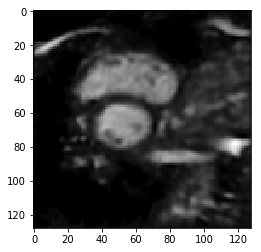

saving epoch {1}
Epoch: 2, Iteration: 1, Loss: 0.007741952780634165, time: 2019-08-02 20:36:45.741258
Epoch: 2, Iteration: 101, Loss: 0.5549996269401163, time: 2019-08-02 20:38:26.830451
150
2019-08-02 20:39:16.344611 Epoch 2, Training loss 0.7605876340530813
torch.Size([1, 1, 128, 128, 20])


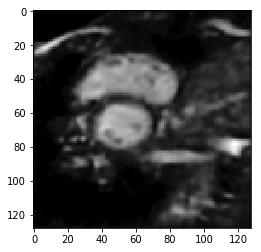

saving epoch {2}
Epoch: 3, Iteration: 1, Loss: 0.005332286469638348, time: 2019-08-02 20:39:17.560501
Epoch: 3, Iteration: 101, Loss: 0.3677071277052164, time: 2019-08-02 20:40:58.574631
150
2019-08-02 20:41:48.082451 Epoch 3, Training loss 0.5460406437050551
torch.Size([1, 1, 128, 128, 20])


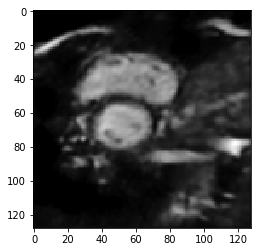

saving epoch {3}
Epoch: 4, Iteration: 1, Loss: 0.0030261953361332417, time: 2019-08-02 20:41:49.309237
Epoch: 4, Iteration: 101, Loss: 0.34318255027756095, time: 2019-08-02 20:43:30.334944
150
2019-08-02 20:44:19.834691 Epoch 4, Training loss 0.5001542665995657
torch.Size([1, 1, 128, 128, 20])


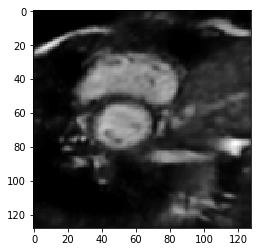

saving epoch {4}
Epoch: 5, Iteration: 1, Loss: 0.003632222767919302, time: 2019-08-02 20:44:21.051122
Epoch: 5, Iteration: 101, Loss: 0.32789574249181896, time: 2019-08-02 20:46:02.053656
150
2019-08-02 20:46:51.558751 Epoch 5, Training loss 0.46756380214355886
torch.Size([1, 1, 128, 128, 20])


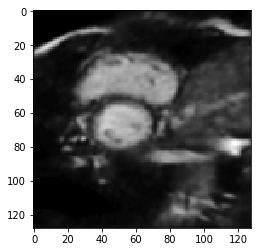

saving epoch {5}
Epoch: 6, Iteration: 1, Loss: 0.0032374535221606493, time: 2019-08-02 20:46:52.774116
Epoch: 6, Iteration: 101, Loss: 0.3026468747993931, time: 2019-08-02 20:48:33.779455
150
2019-08-02 20:49:23.283318 Epoch 6, Training loss 0.4444991935743019
torch.Size([1, 1, 128, 128, 20])


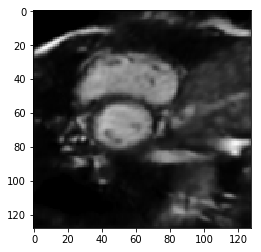

saving epoch {6}
Epoch: 7, Iteration: 1, Loss: 0.004005749709904194, time: 2019-08-02 20:49:24.493512
Epoch: 7, Iteration: 101, Loss: 0.2909291270188987, time: 2019-08-02 20:51:05.490524
150
2019-08-02 20:51:54.975749 Epoch 7, Training loss 0.42794383177533746
torch.Size([1, 1, 128, 128, 20])


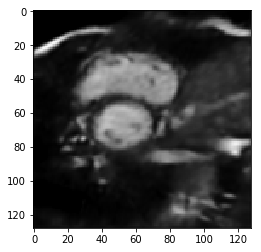

saving epoch {7}
Epoch: 8, Iteration: 1, Loss: 0.0033224080689251423, time: 2019-08-02 20:51:56.187933
Epoch: 8, Iteration: 101, Loss: 0.2791366968303919, time: 2019-08-02 20:53:37.178338
150
2019-08-02 20:54:26.680365 Epoch 8, Training loss 0.41300687310285866
torch.Size([1, 1, 128, 128, 20])


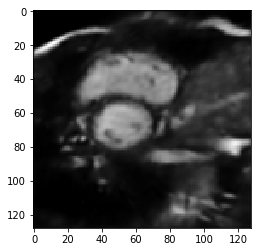

saving epoch {8}
Epoch: 9, Iteration: 1, Loss: 0.0027209699619561434, time: 2019-08-02 20:54:28.025592
Epoch: 9, Iteration: 101, Loss: 0.26788800803478807, time: 2019-08-02 20:56:08.954161
150
2019-08-02 20:56:58.443071 Epoch 9, Training loss 0.39673310541547835
torch.Size([1, 1, 128, 128, 20])


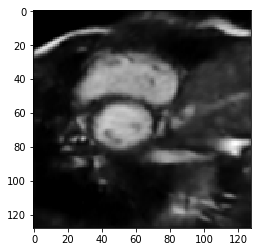

saving epoch {9}
Epoch: 10, Iteration: 1, Loss: 0.0021586555521935225, time: 2019-08-02 20:56:59.648158
Epoch: 10, Iteration: 101, Loss: 0.2562183958943933, time: 2019-08-02 20:58:40.607908
150
2019-08-02 20:59:30.080546 Epoch 10, Training loss 0.3887016692897305
torch.Size([1, 1, 128, 128, 20])


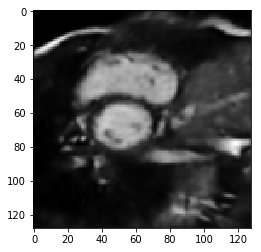

saving epoch {10}
Epoch: 11, Iteration: 1, Loss: 0.0019796208944171667, time: 2019-08-02 20:59:31.305907
Epoch: 11, Iteration: 101, Loss: 0.26578297663945705, time: 2019-08-02 21:01:12.298004
150
2019-08-02 21:02:01.792462 Epoch 11, Training loss 0.38484412932302803
torch.Size([1, 1, 128, 128, 20])


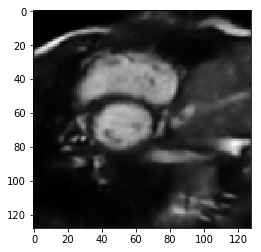

saving epoch {11}
Epoch: 12, Iteration: 1, Loss: 0.0033385660499334335, time: 2019-08-02 21:02:03.008701
Epoch: 12, Iteration: 101, Loss: 0.24913302448112518, time: 2019-08-02 21:03:43.995874
150
2019-08-02 21:04:33.473774 Epoch 12, Training loss 0.3722649588016793
torch.Size([1, 1, 128, 128, 20])


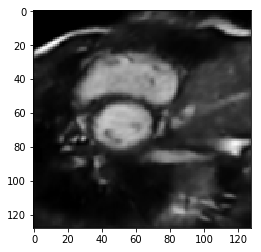

saving epoch {12}
Epoch: 13, Iteration: 1, Loss: 0.0022204818669706583, time: 2019-08-02 21:04:34.692402
Epoch: 13, Iteration: 101, Loss: 0.24580756470095366, time: 2019-08-02 21:06:15.721034
150
2019-08-02 21:07:05.192995 Epoch 13, Training loss 0.3655182784423232
torch.Size([1, 1, 128, 128, 20])


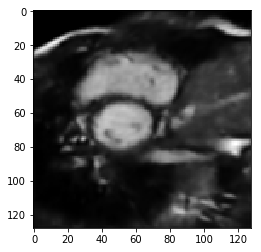

saving epoch {13}
Epoch: 14, Iteration: 1, Loss: 0.002182855736464262, time: 2019-08-02 21:07:06.406806
Epoch: 14, Iteration: 101, Loss: 0.2402429070789367, time: 2019-08-02 21:08:47.435974
150
2019-08-02 21:09:36.939431 Epoch 14, Training loss 0.351525871665217
torch.Size([1, 1, 128, 128, 20])


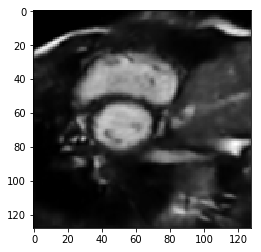

saving epoch {14}
Epoch: 15, Iteration: 1, Loss: 0.002014883328229189, time: 2019-08-02 21:09:38.146601
Epoch: 15, Iteration: 101, Loss: 0.23092965479008853, time: 2019-08-02 21:11:19.157219
150
2019-08-02 21:12:08.685869 Epoch 15, Training loss 0.3438099027844146
torch.Size([1, 1, 128, 128, 20])


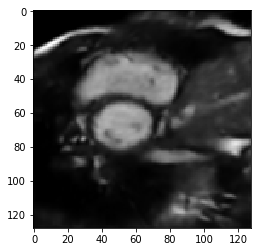

saving epoch {15}
Epoch: 16, Iteration: 1, Loss: 0.0019195532659068704, time: 2019-08-02 21:12:09.903258
Epoch: 16, Iteration: 101, Loss: 0.22630153130739927, time: 2019-08-02 21:13:50.931642
150
2019-08-02 21:14:40.412997 Epoch 16, Training loss 0.3383451619883999
torch.Size([1, 1, 128, 128, 20])


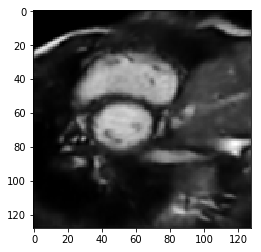

saving epoch {16}
Epoch: 17, Iteration: 1, Loss: 0.0025288185570389032, time: 2019-08-02 21:14:41.622331
Epoch: 17, Iteration: 101, Loss: 0.2228068687254563, time: 2019-08-02 21:16:22.593961
150
2019-08-02 21:17:12.092427 Epoch 17, Training loss 0.32892888388596475
torch.Size([1, 1, 128, 128, 20])


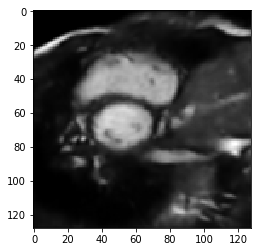

saving epoch {17}
Epoch: 18, Iteration: 1, Loss: 0.0022581007797271013, time: 2019-08-02 21:17:13.300208
Epoch: 18, Iteration: 101, Loss: 0.21824814018327743, time: 2019-08-02 21:18:54.273386
150
2019-08-02 21:19:43.740732 Epoch 18, Training loss 0.3235010093776509
torch.Size([1, 1, 128, 128, 20])


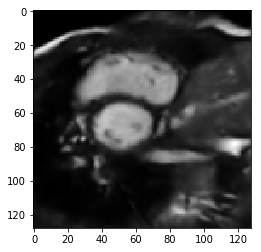

saving epoch {18}
Epoch: 19, Iteration: 1, Loss: 0.0023831205908209085, time: 2019-08-02 21:19:44.953082
Epoch: 19, Iteration: 101, Loss: 0.21306061767973006, time: 2019-08-02 21:21:25.945870
150
2019-08-02 21:22:15.442722 Epoch 19, Training loss 0.320486155571416
torch.Size([1, 1, 128, 128, 20])


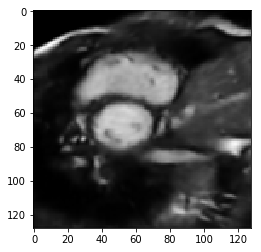

saving epoch {19}
Epoch: 20, Iteration: 1, Loss: 0.0015330343740060925, time: 2019-08-02 21:22:16.655923
Epoch: 20, Iteration: 101, Loss: 0.21292083885055035, time: 2019-08-02 21:23:57.604555
150
2019-08-02 21:24:47.071117 Epoch 20, Training loss 0.31885595549829304
torch.Size([1, 1, 128, 128, 20])


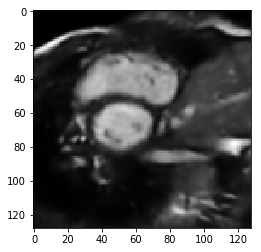

saving epoch {20}
Epoch: 21, Iteration: 1, Loss: 0.0018086401978507638, time: 2019-08-02 21:24:48.285898
Epoch: 21, Iteration: 101, Loss: 0.196125318412669, time: 2019-08-02 21:26:29.263432
150
2019-08-02 21:27:18.726791 Epoch 21, Training loss 0.29331976419780403
torch.Size([1, 1, 128, 128, 20])


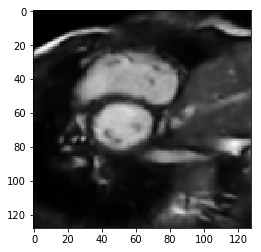

saving epoch {21}
Epoch: 22, Iteration: 1, Loss: 0.0018817350501194596, time: 2019-08-02 21:27:19.932778
Epoch: 22, Iteration: 101, Loss: 0.19871577096637338, time: 2019-08-02 21:29:00.891581
150
2019-08-02 21:29:50.369224 Epoch 22, Training loss 0.2944472838426009
torch.Size([1, 1, 128, 128, 20])


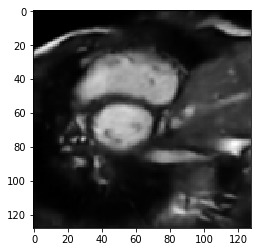

saving epoch {22}
Epoch: 23, Iteration: 1, Loss: 0.0021510354708880186, time: 2019-08-02 21:29:51.577466
Epoch: 23, Iteration: 101, Loss: 0.1999466202687472, time: 2019-08-02 21:31:32.542147
150
2019-08-02 21:32:22.038101 Epoch 23, Training loss 0.29916024662088603
torch.Size([1, 1, 128, 128, 20])


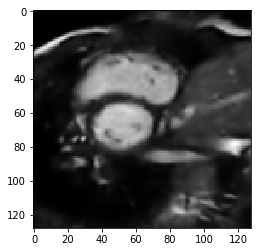

saving epoch {23}
Epoch: 24, Iteration: 1, Loss: 0.001731163589283824, time: 2019-08-02 21:32:23.258055
Epoch: 24, Iteration: 101, Loss: 0.19242581666912884, time: 2019-08-02 21:34:04.292153
150
2019-08-02 21:34:53.800274 Epoch 24, Training loss 0.2908890990074724
torch.Size([1, 1, 128, 128, 20])


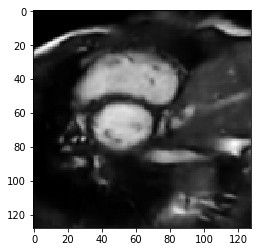

saving epoch {24}
Epoch: 25, Iteration: 1, Loss: 0.00249713147059083, time: 2019-08-02 21:34:55.021809
Epoch: 25, Iteration: 101, Loss: 0.1956392222782597, time: 2019-08-02 21:36:36.049602
150
2019-08-02 21:37:25.529244 Epoch 25, Training loss 0.28474811441265047
torch.Size([1, 1, 128, 128, 20])


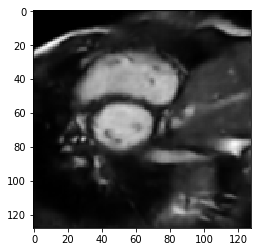

saving epoch {25}
Epoch: 26, Iteration: 1, Loss: 0.0014292815467342734, time: 2019-08-02 21:37:26.741777
Epoch: 26, Iteration: 101, Loss: 0.1826760668773204, time: 2019-08-02 21:39:07.715901
150
2019-08-02 21:39:57.182993 Epoch 26, Training loss 0.27719693700782955
torch.Size([1, 1, 128, 128, 20])


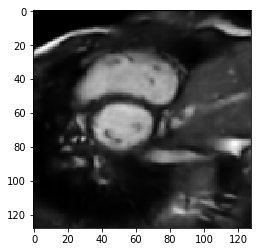

saving epoch {26}
Epoch: 27, Iteration: 1, Loss: 0.0054030753672122955, time: 2019-08-02 21:39:58.404677
Epoch: 27, Iteration: 101, Loss: 0.18404923076741397, time: 2019-08-02 21:41:39.430414
150
2019-08-02 21:42:28.937615 Epoch 27, Training loss 0.2711508683860302
torch.Size([1, 1, 128, 128, 20])


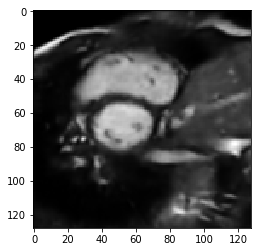

saving epoch {27}
Epoch: 28, Iteration: 1, Loss: 0.0013614663621410728, time: 2019-08-02 21:42:30.142967
Epoch: 28, Iteration: 101, Loss: 0.17797985160723329, time: 2019-08-02 21:44:11.167252
150
2019-08-02 21:45:00.684858 Epoch 28, Training loss 0.2671062268782407
torch.Size([1, 1, 128, 128, 20])


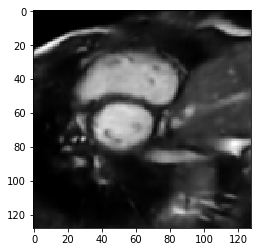

saving epoch {28}
Epoch: 29, Iteration: 1, Loss: 0.0023932596668601036, time: 2019-08-02 21:45:01.893784
Epoch: 29, Iteration: 101, Loss: 0.17768024548422545, time: 2019-08-02 21:46:42.844941
150
2019-08-02 21:47:32.357109 Epoch 29, Training loss 0.2566042293328792
torch.Size([1, 1, 128, 128, 20])


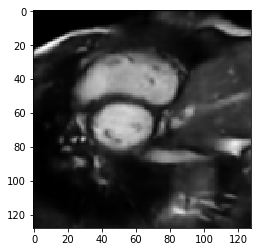

saving epoch {29}
Epoch: 30, Iteration: 1, Loss: 0.0013722021831199527, time: 2019-08-02 21:47:33.567006
Epoch: 30, Iteration: 101, Loss: 0.16806375340092927, time: 2019-08-02 21:49:14.590362
150
2019-08-02 21:50:04.119385 Epoch 30, Training loss 0.24420732725411654
torch.Size([1, 1, 128, 128, 20])


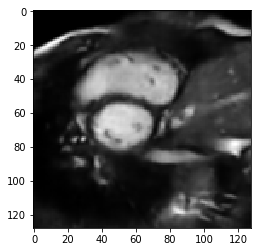

saving epoch {30}
Epoch: 31, Iteration: 1, Loss: 0.001382508547976613, time: 2019-08-02 21:50:05.336468
Epoch: 31, Iteration: 101, Loss: 0.1570442746160552, time: 2019-08-02 21:51:46.355731
150
2019-08-02 21:52:35.822617 Epoch 31, Training loss 0.2380637121386826
torch.Size([1, 1, 128, 128, 20])


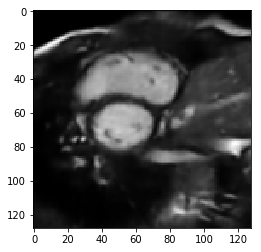

saving epoch {31}
Epoch: 32, Iteration: 1, Loss: 0.0015212863218039274, time: 2019-08-02 21:52:37.029153
Epoch: 32, Iteration: 101, Loss: 0.16295887029264122, time: 2019-08-02 21:54:18.005938
150
2019-08-02 21:55:07.477426 Epoch 32, Training loss 0.23781957011669874
torch.Size([1, 1, 128, 128, 20])


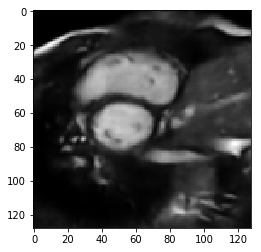

saving epoch {32}
Epoch: 33, Iteration: 1, Loss: 0.0013006014050915837, time: 2019-08-02 21:55:08.690598
Epoch: 33, Iteration: 101, Loss: 0.1592538703698665, time: 2019-08-02 21:56:49.728487
150
2019-08-02 21:57:39.244826 Epoch 33, Training loss 0.23422533215489239
torch.Size([1, 1, 128, 128, 20])


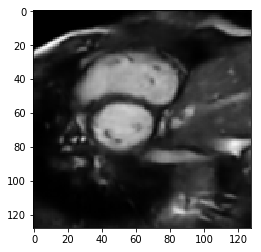

saving epoch {33}
Epoch: 34, Iteration: 1, Loss: 0.0014295943547040224, time: 2019-08-02 21:57:40.459207
Epoch: 34, Iteration: 101, Loss: 0.15168979851296172, time: 2019-08-02 21:59:21.478379
150
2019-08-02 22:00:10.944789 Epoch 34, Training loss 0.22239026380702853
torch.Size([1, 1, 128, 128, 20])


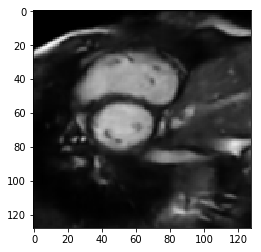

saving epoch {34}
Epoch: 35, Iteration: 1, Loss: 0.0015147820813581347, time: 2019-08-02 22:00:12.152259
Epoch: 35, Iteration: 101, Loss: 0.14854680828284472, time: 2019-08-02 22:01:53.199913
150
2019-08-02 22:02:42.699521 Epoch 35, Training loss 0.2228384466143325
torch.Size([1, 1, 128, 128, 20])


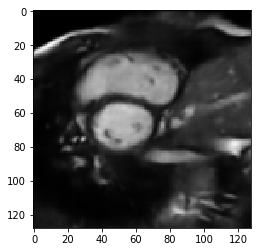

saving epoch {35}
Epoch: 36, Iteration: 1, Loss: 0.0012077392311766744, time: 2019-08-02 22:02:43.916073
Epoch: 36, Iteration: 101, Loss: 0.14290002291090786, time: 2019-08-02 22:04:24.868580
150
2019-08-02 22:05:14.344063 Epoch 36, Training loss 0.21411966776940972
torch.Size([1, 1, 128, 128, 20])


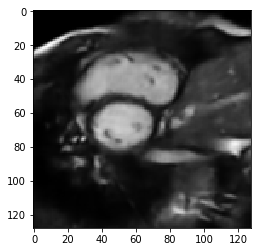

saving epoch {36}
Epoch: 37, Iteration: 1, Loss: 0.0011899769306182861, time: 2019-08-02 22:05:15.709732
Epoch: 37, Iteration: 101, Loss: 0.14165972138289362, time: 2019-08-02 22:06:56.659710
150
2019-08-02 22:07:46.128687 Epoch 37, Training loss 0.21315815049456432
torch.Size([1, 1, 128, 128, 20])


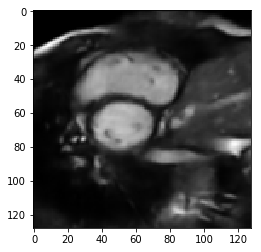

saving epoch {37}
Epoch: 38, Iteration: 1, Loss: 0.0013325739419087768, time: 2019-08-02 22:07:47.350477
Epoch: 38, Iteration: 101, Loss: 0.13805165811209008, time: 2019-08-02 22:09:28.318702
150
2019-08-02 22:10:17.804201 Epoch 38, Training loss 0.20572489028563723
torch.Size([1, 1, 128, 128, 20])


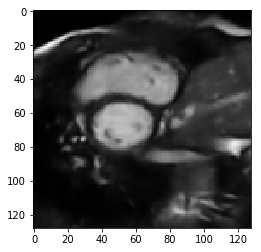

saving epoch {38}
Epoch: 39, Iteration: 1, Loss: 0.0016478843754157424, time: 2019-08-02 22:10:19.016025
Epoch: 39, Iteration: 101, Loss: 0.14011988078709692, time: 2019-08-02 22:11:59.961474
150
2019-08-02 22:12:49.426905 Epoch 39, Training loss 0.2125542543362826
torch.Size([1, 1, 128, 128, 20])


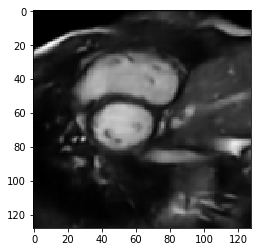

saving epoch {39}
Epoch: 40, Iteration: 1, Loss: 0.001110183191485703, time: 2019-08-02 22:12:50.634385
Epoch: 40, Iteration: 101, Loss: 0.13475190778262913, time: 2019-08-02 22:14:31.641851
150
2019-08-02 22:15:21.138390 Epoch 40, Training loss 0.20017243648180738
torch.Size([1, 1, 128, 128, 20])


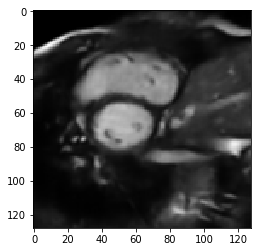

saving epoch {40}
Epoch: 41, Iteration: 1, Loss: 0.0013741613365709782, time: 2019-08-02 22:15:22.343916
Epoch: 41, Iteration: 101, Loss: 0.13856336910976097, time: 2019-08-02 22:17:03.308689
150
2019-08-02 22:17:52.803083 Epoch 41, Training loss 0.2067204636405222
torch.Size([1, 1, 128, 128, 20])


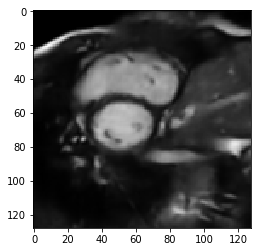

saving epoch {41}
Epoch: 42, Iteration: 1, Loss: 0.0016777102136984468, time: 2019-08-02 22:17:54.007566
Epoch: 42, Iteration: 101, Loss: 0.13672424032120034, time: 2019-08-02 22:19:34.949139
150
2019-08-02 22:20:24.465804 Epoch 42, Training loss 0.20410093577811494
torch.Size([1, 1, 128, 128, 20])


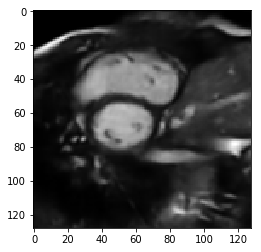

saving epoch {42}
Epoch: 43, Iteration: 1, Loss: 0.0012593764113262296, time: 2019-08-02 22:20:25.678119
Epoch: 43, Iteration: 101, Loss: 0.1270679587032646, time: 2019-08-02 22:22:06.727242
150
2019-08-02 22:22:56.229749 Epoch 43, Training loss 0.19455464580096304
torch.Size([1, 1, 128, 128, 20])


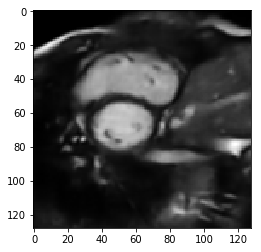

saving epoch {43}
Epoch: 44, Iteration: 1, Loss: 0.00314133008942008, time: 2019-08-02 22:22:57.440285
Epoch: 44, Iteration: 101, Loss: 0.133824497112073, time: 2019-08-02 22:24:38.476891
150
2019-08-02 22:25:28.005497 Epoch 44, Training loss 0.19894099683733657
torch.Size([1, 1, 128, 128, 20])


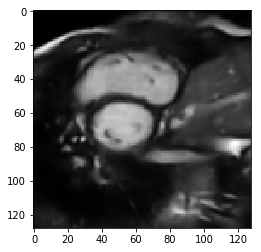

saving epoch {44}
Epoch: 45, Iteration: 1, Loss: 0.0014077298110350966, time: 2019-08-02 22:25:29.221714
Epoch: 45, Iteration: 101, Loss: 0.12649107648758218, time: 2019-08-02 22:27:10.228908
150
2019-08-02 22:27:59.719285 Epoch 45, Training loss 0.18820799503009766
torch.Size([1, 1, 128, 128, 20])


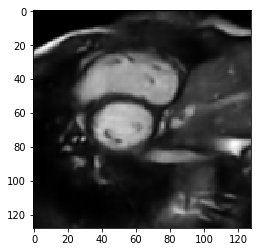

saving epoch {45}
Epoch: 46, Iteration: 1, Loss: 0.0014716206351295114, time: 2019-08-02 22:28:00.931793
Epoch: 46, Iteration: 101, Loss: 0.12774126924341545, time: 2019-08-02 22:29:41.955305
150
2019-08-02 22:30:31.421117 Epoch 46, Training loss 0.18972191476495937
torch.Size([1, 1, 128, 128, 20])


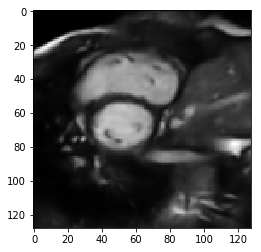

saving epoch {46}
Epoch: 47, Iteration: 1, Loss: 0.002390365581959486, time: 2019-08-02 22:30:32.631641
Epoch: 47, Iteration: 101, Loss: 0.13002974522532895, time: 2019-08-02 22:32:13.658217
150
2019-08-02 22:33:03.143409 Epoch 47, Training loss 0.1933034737012349
torch.Size([1, 1, 128, 128, 20])


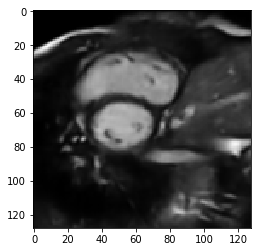

saving epoch {47}
Epoch: 48, Iteration: 1, Loss: 0.0011493437923491001, time: 2019-08-02 22:33:04.346336
Epoch: 48, Iteration: 101, Loss: 0.1286392756155692, time: 2019-08-02 22:34:45.375487
150
2019-08-02 22:35:34.878800 Epoch 48, Training loss 0.19011902931379154
torch.Size([1, 1, 128, 128, 20])


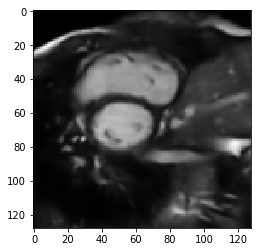

saving epoch {48}
Epoch: 49, Iteration: 1, Loss: 0.0009591790148988366, time: 2019-08-02 22:35:36.098343
Epoch: 49, Iteration: 101, Loss: 0.1213204771047458, time: 2019-08-02 22:37:17.130271
150
2019-08-02 22:38:06.622002 Epoch 49, Training loss 0.18539351876825094
torch.Size([1, 1, 128, 128, 20])


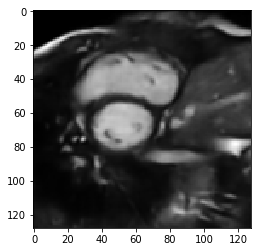

saving epoch {49}
Epoch: 50, Iteration: 1, Loss: 0.0011733639985322952, time: 2019-08-02 22:38:07.821240
Epoch: 50, Iteration: 101, Loss: 0.11787212488707155, time: 2019-08-02 22:39:48.864086
150
2019-08-02 22:40:38.359147 Epoch 50, Training loss 0.1800936553045176
torch.Size([1, 1, 128, 128, 20])


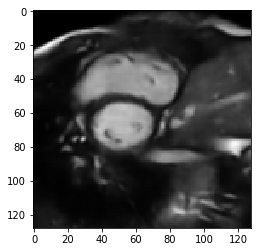

saving epoch {50}
Epoch: 51, Iteration: 1, Loss: 0.0011502134148031473, time: 2019-08-02 22:40:39.568814
Epoch: 51, Iteration: 101, Loss: 0.12527292093727738, time: 2019-08-02 22:42:20.573045
150
2019-08-02 22:43:10.064766 Epoch 51, Training loss 0.18278838670812547
torch.Size([1, 1, 128, 128, 20])


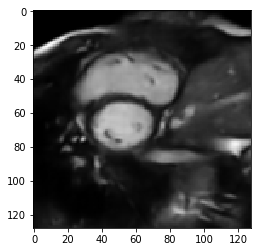

saving epoch {51}
Epoch: 52, Iteration: 1, Loss: 0.0010105313267558813, time: 2019-08-02 22:43:11.296237
Epoch: 52, Iteration: 101, Loss: 0.11609457869781181, time: 2019-08-02 22:44:52.301519
150
2019-08-02 22:45:41.811879 Epoch 52, Training loss 0.17652523226570338
torch.Size([1, 1, 128, 128, 20])


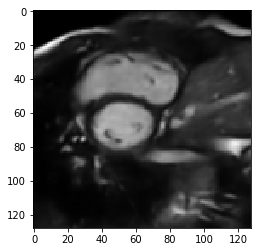

saving epoch {52}
Epoch: 53, Iteration: 1, Loss: 0.000725434219930321, time: 2019-08-02 22:45:43.016055
Epoch: 53, Iteration: 101, Loss: 0.12360817065928131, time: 2019-08-02 22:47:24.061993
150
2019-08-02 22:48:13.509149 Epoch 53, Training loss 0.1801371497567743
torch.Size([1, 1, 128, 128, 20])


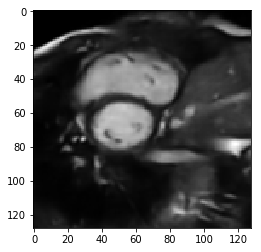

saving epoch {53}
Epoch: 54, Iteration: 1, Loss: 0.0008911965414881706, time: 2019-08-02 22:48:14.718563
Epoch: 54, Iteration: 101, Loss: 0.11664109682897106, time: 2019-08-02 22:49:55.743171
150
2019-08-02 22:50:45.276344 Epoch 54, Training loss 0.1722013372927904
torch.Size([1, 1, 128, 128, 20])


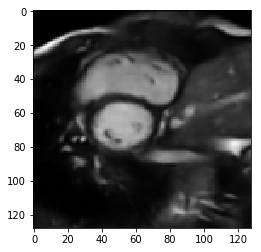

saving epoch {54}
Epoch: 55, Iteration: 1, Loss: 0.0009917684365063906, time: 2019-08-02 22:50:46.488332
Epoch: 55, Iteration: 101, Loss: 0.12233400595141575, time: 2019-08-02 22:52:27.551467
150
2019-08-02 22:53:17.056486 Epoch 55, Training loss 0.19012154801748693
torch.Size([1, 1, 128, 128, 20])


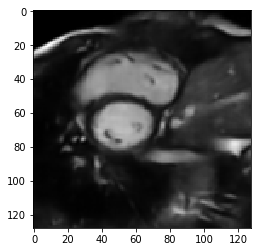

saving epoch {55}
Epoch: 56, Iteration: 1, Loss: 0.0008522464195266366, time: 2019-08-02 22:53:18.269361
Epoch: 56, Iteration: 101, Loss: 0.12306213757256046, time: 2019-08-02 22:54:59.355048
150
2019-08-02 22:55:48.888383 Epoch 56, Training loss 0.18274844367988408
torch.Size([1, 1, 128, 128, 20])


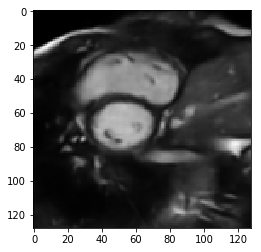

saving epoch {56}
Epoch: 57, Iteration: 1, Loss: 0.0007926722755655646, time: 2019-08-02 22:55:50.107155
Epoch: 57, Iteration: 101, Loss: 0.11990400805370882, time: 2019-08-02 22:57:31.207627
150
2019-08-02 22:58:20.745356 Epoch 57, Training loss 0.17344642343232408
torch.Size([1, 1, 128, 128, 20])


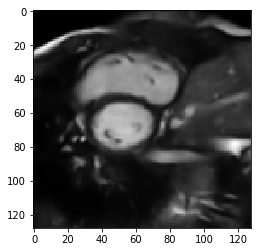

saving epoch {57}
Epoch: 58, Iteration: 1, Loss: 0.0007592454785481095, time: 2019-08-02 22:58:21.956272
Epoch: 58, Iteration: 101, Loss: 0.10990078962640837, time: 2019-08-02 23:00:03.003277
150
2019-08-02 23:00:52.531107 Epoch 58, Training loss 0.17029346758499742
torch.Size([1, 1, 128, 128, 20])


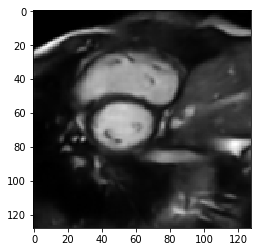

saving epoch {58}
Epoch: 59, Iteration: 1, Loss: 0.0008509933832101524, time: 2019-08-02 23:00:53.737116
Epoch: 59, Iteration: 101, Loss: 0.121474411978852, time: 2019-08-02 23:02:34.780127
150
2019-08-02 23:03:24.287160 Epoch 59, Training loss 0.1757119025569409
torch.Size([1, 1, 128, 128, 20])


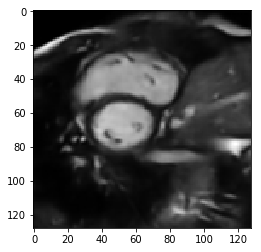

saving epoch {59}
Epoch: 60, Iteration: 1, Loss: 0.0012423190055415034, time: 2019-08-02 23:03:25.495827
Epoch: 60, Iteration: 101, Loss: 0.1136182543123141, time: 2019-08-02 23:05:06.557096
150
2019-08-02 23:05:56.055696 Epoch 60, Training loss 0.16900702903512865
torch.Size([1, 1, 128, 128, 20])


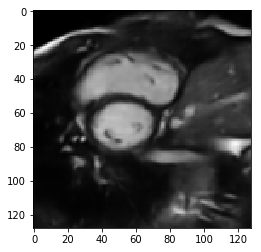

saving epoch {60}
Epoch: 61, Iteration: 1, Loss: 0.0007630444597452879, time: 2019-08-02 23:05:57.263521
Epoch: 61, Iteration: 101, Loss: 0.11873833165736869, time: 2019-08-02 23:07:38.291819
150
2019-08-02 23:08:27.798060 Epoch 61, Training loss 0.17249065171927214
torch.Size([1, 1, 128, 128, 20])


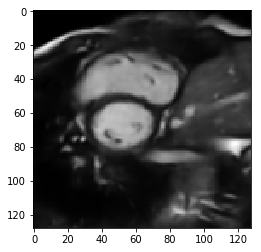

saving epoch {61}
Epoch: 62, Iteration: 1, Loss: 0.0012044102186337113, time: 2019-08-02 23:08:29.003304
Epoch: 62, Iteration: 101, Loss: 0.11487817839952186, time: 2019-08-02 23:10:10.003479
150
2019-08-02 23:10:59.503734 Epoch 62, Training loss 0.17440908373100683
torch.Size([1, 1, 128, 128, 20])


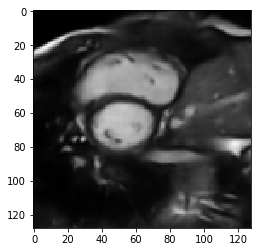

saving epoch {62}
Epoch: 63, Iteration: 1, Loss: 0.002319073537364602, time: 2019-08-02 23:11:00.713177
Epoch: 63, Iteration: 101, Loss: 0.11471801233710721, time: 2019-08-02 23:12:41.720630
150
2019-08-02 23:13:31.216534 Epoch 63, Training loss 0.17054731759708375
torch.Size([1, 1, 128, 128, 20])


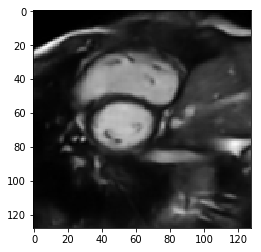

saving epoch {63}
Epoch: 64, Iteration: 1, Loss: 0.0007832730188965797, time: 2019-08-02 23:13:32.570100
Epoch: 64, Iteration: 101, Loss: 0.11219041049480438, time: 2019-08-02 23:15:13.580675
150
2019-08-02 23:16:03.077784 Epoch 64, Training loss 0.16968266910407692
torch.Size([1, 1, 128, 128, 20])


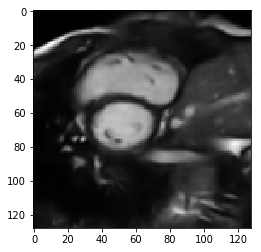

saving epoch {64}
Epoch: 65, Iteration: 1, Loss: 0.0010133705800399184, time: 2019-08-02 23:16:04.286665
Epoch: 65, Iteration: 101, Loss: 0.11396091873757541, time: 2019-08-02 23:17:45.292196
150
2019-08-02 23:18:34.779376 Epoch 65, Training loss 0.16561773919966072
torch.Size([1, 1, 128, 128, 20])


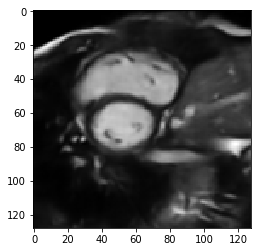

saving epoch {65}
Epoch: 66, Iteration: 1, Loss: 0.000727947277482599, time: 2019-08-02 23:18:35.991521
Epoch: 66, Iteration: 101, Loss: 0.10934292513411492, time: 2019-08-02 23:20:17.039542
150
2019-08-02 23:21:06.525431 Epoch 66, Training loss 0.1655462108901702
torch.Size([1, 1, 128, 128, 20])


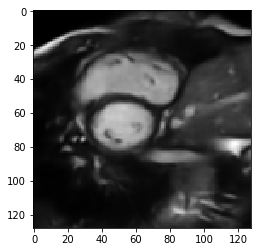

saving epoch {66}
Epoch: 67, Iteration: 1, Loss: 0.0009378939867019653, time: 2019-08-02 23:21:07.737868
Epoch: 67, Iteration: 101, Loss: 0.10507560474798083, time: 2019-08-02 23:22:48.779392
150
2019-08-02 23:23:38.273920 Epoch 67, Training loss 0.15864165866514668
torch.Size([1, 1, 128, 128, 20])


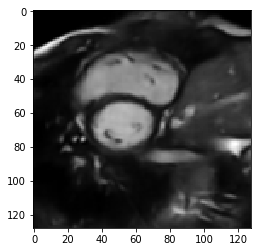

saving epoch {67}
Epoch: 68, Iteration: 1, Loss: 0.0007764417678117752, time: 2019-08-02 23:23:39.487560
Epoch: 68, Iteration: 101, Loss: 0.11032424558652565, time: 2019-08-02 23:25:20.546153
150
2019-08-02 23:26:10.046840 Epoch 68, Training loss 0.16244033206021413
torch.Size([1, 1, 128, 128, 20])


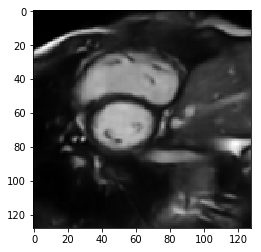

saving epoch {68}
Epoch: 69, Iteration: 1, Loss: 0.0008854363113641739, time: 2019-08-02 23:26:11.321797
Epoch: 69, Iteration: 101, Loss: 0.10557506972691044, time: 2019-08-02 23:27:52.375388
150
2019-08-02 23:28:41.894882 Epoch 69, Training loss 0.16256252629682422
torch.Size([1, 1, 128, 128, 20])


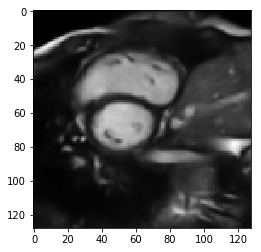

saving epoch {69}
Epoch: 70, Iteration: 1, Loss: 0.0013478316832333803, time: 2019-08-02 23:28:43.106171
Epoch: 70, Iteration: 101, Loss: 0.10989719140343368, time: 2019-08-02 23:30:24.120928
150
2019-08-02 23:31:13.602563 Epoch 70, Training loss 0.15954424819210544
torch.Size([1, 1, 128, 128, 20])


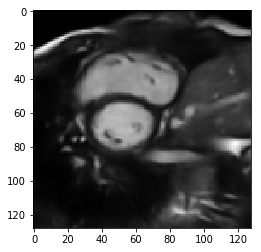

saving epoch {70}
Epoch: 71, Iteration: 1, Loss: 0.0007116923807188869, time: 2019-08-02 23:31:14.808898
Epoch: 71, Iteration: 101, Loss: 0.10516414017183706, time: 2019-08-02 23:32:55.735208
150
2019-08-02 23:33:45.206524 Epoch 71, Training loss 0.1566096130409278
torch.Size([1, 1, 128, 128, 20])


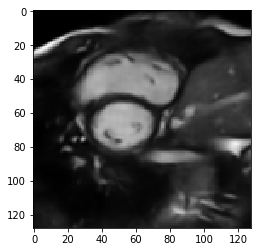

saving epoch {71}
Epoch: 72, Iteration: 1, Loss: 0.0009911989327520132, time: 2019-08-02 23:33:46.419341
Epoch: 72, Iteration: 101, Loss: 0.11381809919839725, time: 2019-08-02 23:35:27.374463
150
2019-08-02 23:36:16.888777 Epoch 72, Training loss 0.16351876157568768
torch.Size([1, 1, 128, 128, 20])


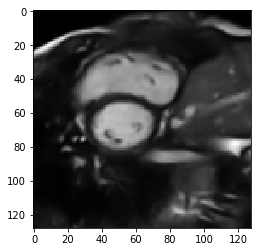

saving epoch {72}
Epoch: 73, Iteration: 1, Loss: 0.001333873369731009, time: 2019-08-02 23:36:18.098995
Epoch: 73, Iteration: 101, Loss: 0.11439589236397296, time: 2019-08-02 23:37:59.058051
150
2019-08-02 23:38:48.524729 Epoch 73, Training loss 0.16721727920230478
torch.Size([1, 1, 128, 128, 20])


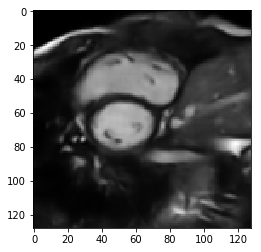

saving epoch {73}
Epoch: 74, Iteration: 1, Loss: 0.0008876061183400452, time: 2019-08-02 23:38:49.740409
Epoch: 74, Iteration: 101, Loss: 0.10521026398055255, time: 2019-08-02 23:40:30.712031
150
2019-08-02 23:41:20.235021 Epoch 74, Training loss 0.15695448056794703
torch.Size([1, 1, 128, 128, 20])


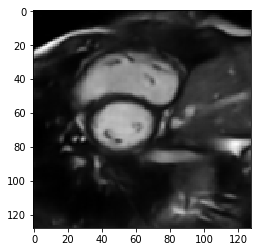

saving epoch {74}
Epoch: 75, Iteration: 1, Loss: 0.0009985275100916624, time: 2019-08-02 23:41:21.444065
Epoch: 75, Iteration: 101, Loss: 0.10509840899612755, time: 2019-08-02 23:43:02.476936
150
2019-08-02 23:43:51.951325 Epoch 75, Training loss 0.15962173586012796
torch.Size([1, 1, 128, 128, 20])


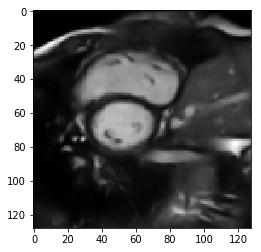

saving epoch {75}
Epoch: 76, Iteration: 1, Loss: 0.0008445441490039229, time: 2019-08-02 23:43:53.153104
Epoch: 76, Iteration: 101, Loss: 0.10970828519202769, time: 2019-08-02 23:45:34.172756
150
2019-08-02 23:46:23.669569 Epoch 76, Training loss 0.15795517450897023
torch.Size([1, 1, 128, 128, 20])


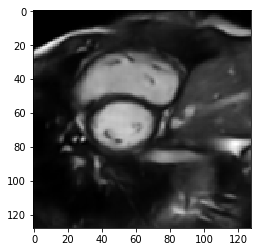

saving epoch {76}
Epoch: 77, Iteration: 1, Loss: 0.0009122638148255646, time: 2019-08-02 23:46:24.868704
Epoch: 77, Iteration: 101, Loss: 0.11016776034375653, time: 2019-08-02 23:48:05.882433
150
2019-08-02 23:48:55.343409 Epoch 77, Training loss 0.16215867875143886
torch.Size([1, 1, 128, 128, 20])


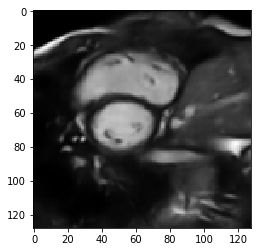

saving epoch {77}
Epoch: 78, Iteration: 1, Loss: 0.0006027359631843865, time: 2019-08-02 23:48:56.554962
Epoch: 78, Iteration: 101, Loss: 0.11128540692152455, time: 2019-08-02 23:50:37.594191
150
2019-08-02 23:51:27.090282 Epoch 78, Training loss 0.16280082403682172
torch.Size([1, 1, 128, 128, 20])


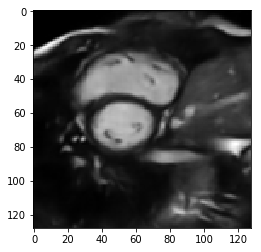

saving epoch {78}
Epoch: 79, Iteration: 1, Loss: 0.0007522278465330601, time: 2019-08-02 23:51:28.299403
Epoch: 79, Iteration: 101, Loss: 0.09626879543066025, time: 2019-08-02 23:53:09.334811
150
2019-08-02 23:53:58.857585 Epoch 79, Training loss 0.14965599513379857
torch.Size([1, 1, 128, 128, 20])


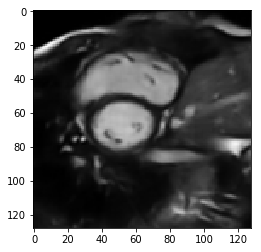

saving epoch {79}
Epoch: 80, Iteration: 1, Loss: 0.0008251183899119496, time: 2019-08-02 23:54:00.064653
Epoch: 80, Iteration: 101, Loss: 0.1053400727105327, time: 2019-08-02 23:55:41.118643
150
2019-08-02 23:56:30.597580 Epoch 80, Training loss 0.15711236745119095
torch.Size([1, 1, 128, 128, 20])


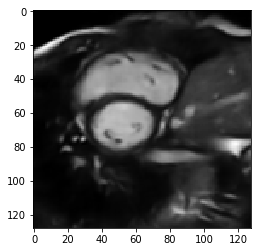

saving epoch {80}
Epoch: 81, Iteration: 1, Loss: 0.0014726545196026564, time: 2019-08-02 23:56:31.858747
Epoch: 81, Iteration: 101, Loss: 0.09740713844075799, time: 2019-08-02 23:58:12.878441
150
2019-08-02 23:59:02.365886 Epoch 81, Training loss 0.1485718804760836
torch.Size([1, 1, 128, 128, 20])


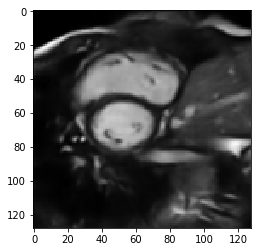

saving epoch {81}
Epoch: 82, Iteration: 1, Loss: 0.001049004727974534, time: 2019-08-02 23:59:03.574132
Epoch: 82, Iteration: 101, Loss: 0.10245915199629962, time: 2019-08-03 00:00:44.646004
150
2019-08-03 00:01:34.169358 Epoch 82, Training loss 0.15325940126786008
torch.Size([1, 1, 128, 128, 20])


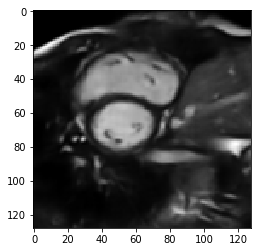

saving epoch {82}
Epoch: 83, Iteration: 1, Loss: 0.0007872598362155259, time: 2019-08-03 00:01:35.380554
Epoch: 83, Iteration: 101, Loss: 0.10583382105687633, time: 2019-08-03 00:03:16.389529
150
2019-08-03 00:04:05.887723 Epoch 83, Training loss 0.15561572858132422
torch.Size([1, 1, 128, 128, 20])


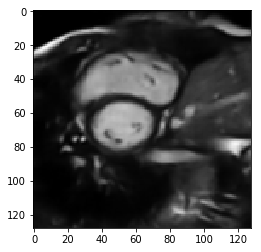

saving epoch {83}
Epoch: 84, Iteration: 1, Loss: 0.0009075117995962501, time: 2019-08-03 00:04:07.094221
Epoch: 84, Iteration: 101, Loss: 0.10601670132018626, time: 2019-08-03 00:05:48.110165
150
2019-08-03 00:06:37.576760 Epoch 84, Training loss 0.15579188702395186
torch.Size([1, 1, 128, 128, 20])


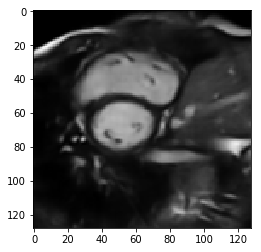

saving epoch {84}
Epoch: 85, Iteration: 1, Loss: 0.0010346437338739634, time: 2019-08-03 00:06:38.785244
Epoch: 85, Iteration: 101, Loss: 0.09706476947758347, time: 2019-08-03 00:08:19.769773
150
2019-08-03 00:09:09.254559 Epoch 85, Training loss 0.15776339080184698
torch.Size([1, 1, 128, 128, 20])


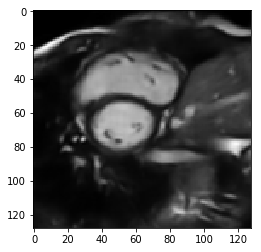

saving epoch {85}
Epoch: 86, Iteration: 1, Loss: 0.0007409085519611835, time: 2019-08-03 00:09:10.461736
Epoch: 86, Iteration: 101, Loss: 0.10630433319602162, time: 2019-08-03 00:10:51.478520
150
2019-08-03 00:11:40.965149 Epoch 86, Training loss 0.15609623829368502
torch.Size([1, 1, 128, 128, 20])


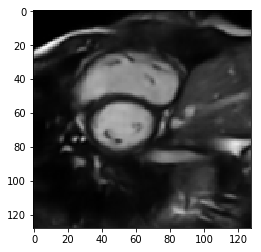

saving epoch {86}
Epoch: 87, Iteration: 1, Loss: 0.0007412340492010117, time: 2019-08-03 00:11:42.179495
Epoch: 87, Iteration: 101, Loss: 0.09949263377347961, time: 2019-08-03 00:13:23.192410
150
2019-08-03 00:14:12.687049 Epoch 87, Training loss 0.14944387489231303
torch.Size([1, 1, 128, 128, 20])


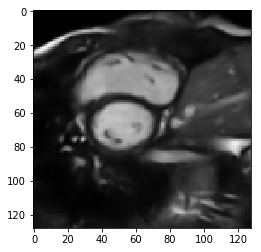

saving epoch {87}
Epoch: 88, Iteration: 1, Loss: 0.0009589770925231278, time: 2019-08-03 00:14:13.884996
Epoch: 88, Iteration: 101, Loss: 0.09912164375418797, time: 2019-08-03 00:15:54.933465
150
2019-08-03 00:16:44.427329 Epoch 88, Training loss 0.1445884873974137
torch.Size([1, 1, 128, 128, 20])


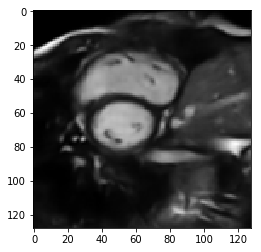

saving epoch {88}
Epoch: 89, Iteration: 1, Loss: 0.0006579175242222846, time: 2019-08-03 00:16:45.639057
Epoch: 89, Iteration: 101, Loss: 0.09529833699343726, time: 2019-08-03 00:18:26.662768
150
2019-08-03 00:19:16.138822 Epoch 89, Training loss 0.14887815876863897
torch.Size([1, 1, 128, 128, 20])


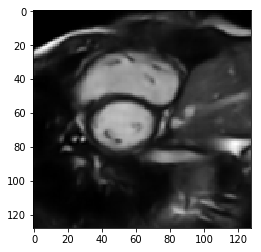

saving epoch {89}
Epoch: 90, Iteration: 1, Loss: 0.0008166170446202159, time: 2019-08-03 00:19:17.345115
Epoch: 90, Iteration: 101, Loss: 0.10744335455819964, time: 2019-08-03 00:20:58.348591
150
2019-08-03 00:21:47.856850 Epoch 90, Training loss 0.15384680026909336
torch.Size([1, 1, 128, 128, 20])


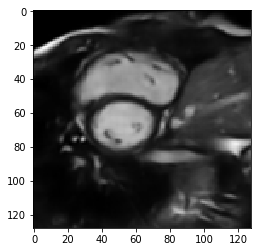

saving epoch {90}
Epoch: 91, Iteration: 1, Loss: 0.0022210776805877686, time: 2019-08-03 00:21:49.217558
Epoch: 91, Iteration: 101, Loss: 0.11702134658116847, time: 2019-08-03 00:23:30.233348
150
2019-08-03 00:24:19.762440 Epoch 91, Training loss 0.16594034153968096
torch.Size([1, 1, 128, 128, 20])


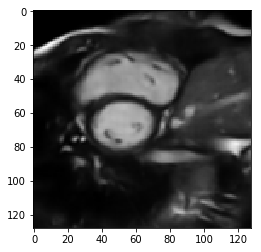

saving epoch {91}
Epoch: 92, Iteration: 1, Loss: 0.0007117523928172886, time: 2019-08-03 00:24:20.976314
Epoch: 92, Iteration: 101, Loss: 0.10241533699445426, time: 2019-08-03 00:26:02.018920
150
2019-08-03 00:26:51.535394 Epoch 92, Training loss 0.14770307583967224
torch.Size([1, 1, 128, 128, 20])


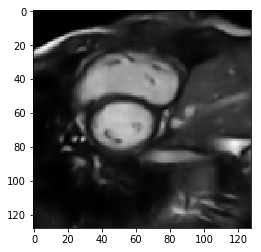

saving epoch {92}
Epoch: 93, Iteration: 1, Loss: 0.0010485707316547632, time: 2019-08-03 00:26:52.748574
Epoch: 93, Iteration: 101, Loss: 0.0944794769748114, time: 2019-08-03 00:28:33.758667
150
2019-08-03 00:29:23.263564 Epoch 93, Training loss 0.1485639055026695
torch.Size([1, 1, 128, 128, 20])


In [ ]:
training_loop(100, optimizer, model, loss_fn, train_loader)

# Training done

# Testing and visualisation 

In [72]:
loss_vec

[1.3152947323396802,
 1.0341966594569385,
 0.9892305156681687,
 0.8666255830321461,
 0.7933209592010826,
 0.6772968422155827,
 0.6212367403786629,
 0.5985592692159116,
 0.5702788236085325,
 0.525107994209975,
 0.5469943103380501,
 0.5129906956572086,
 0.4867403422249481,
 0.4611711842007935,
 0.47429577470757067,
 0.4641416980884969,
 0.45420624734833837,
 0.43278275965712965,
 0.464258442283608,
 0.4149524482199922,
 0.41688075836282223,
 0.41837401292286813,
 0.4037642932962626,
 0.39999858499504626,
 0.4113213325617835,
 0.4056990403914824,
 0.3831325031351298,
 0.3786763728130609,
 0.3669783108634874,
 0.36474855872802436,
 0.35035125666763633,
 0.3503992985934019,
 0.3402437148615718,
 0.3351590581005439,
 0.3374122465029359,
 0.33556001249235123,
 0.3328486067475751,
 0.31072598381433636,
 0.30814393539913,
 0.2983350455760956,
 0.2890657923417166,
 0.3048023988958448,
 0.28251228213775903,
 0.2730137414764613,
 0.29023835517000407,
 0.2702494567492977,
 0.28599959216080606,
 0.2

In [100]:
len(loss_vec)

100

Text(0, 0.5, 'MSE Loss')

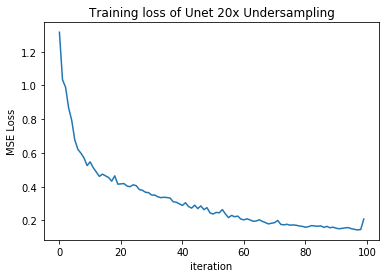

In [104]:
plt.plot(np.arange(100), loss_vec[0:100])
plt.title("Training loss of Unet 20x Undersampling")
plt.xlabel('iteration')
plt.ylabel('MSE Loss')

In [106]:
result_vec = []

In [107]:
for k in range(222):
    a = test_recon[k:k+1,:,:,:,:]
    a = a.float()
    result = model(a.to(device))
    result = result.to('cpu')
    result = result.detach()
    result = result.numpy()
    result_vec.append(result)

In [108]:
len(result_vec)

222

In [109]:
res_save = np.ndarray((128,128,200,222))

In [110]:
a = torch.FloatTensor(result_vec)

In [111]:
a.shape

torch.Size([222, 1, 1, 128, 128, 20])

In [112]:
a = a.permute(0,3,4,5,1,2)

In [113]:
b = a[:,:,:,:,0,0]

In [114]:
b.shape

torch.Size([222, 128, 128, 20])

In [115]:
b = b.numpy()

In [93]:
import scipy.io

In [94]:
scipy.io.savemat('Results_unet_20und_100epoch.mat', {'recon':b})

In [116]:
result_vec[0].shape

(1, 1, 128, 128, 20)

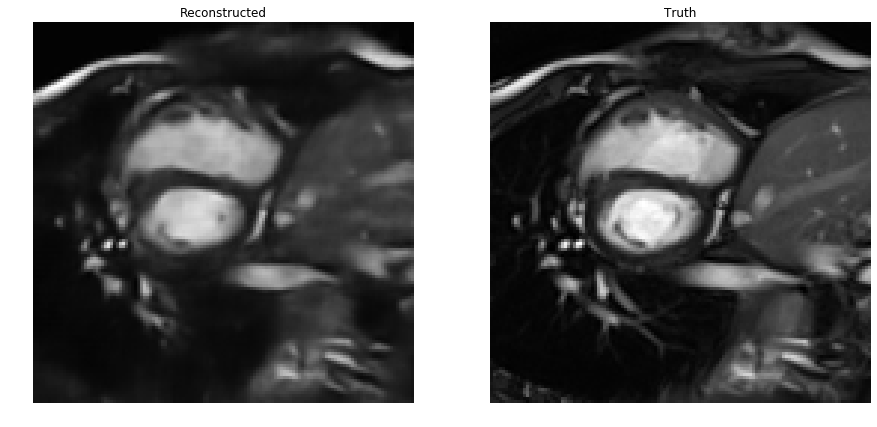

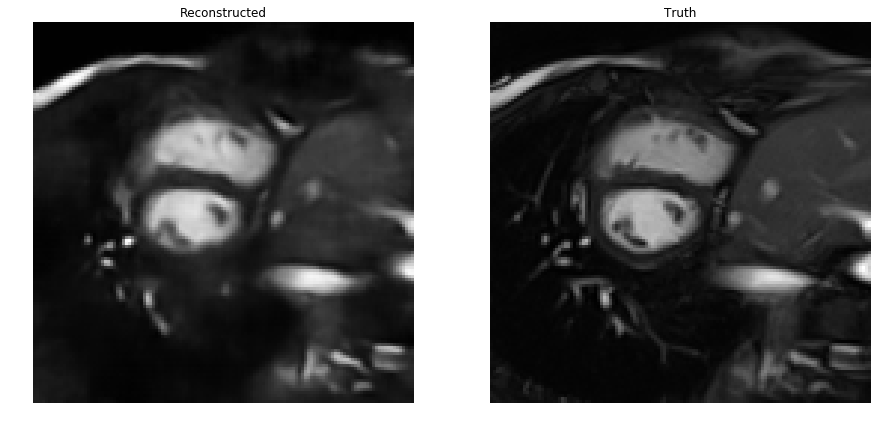

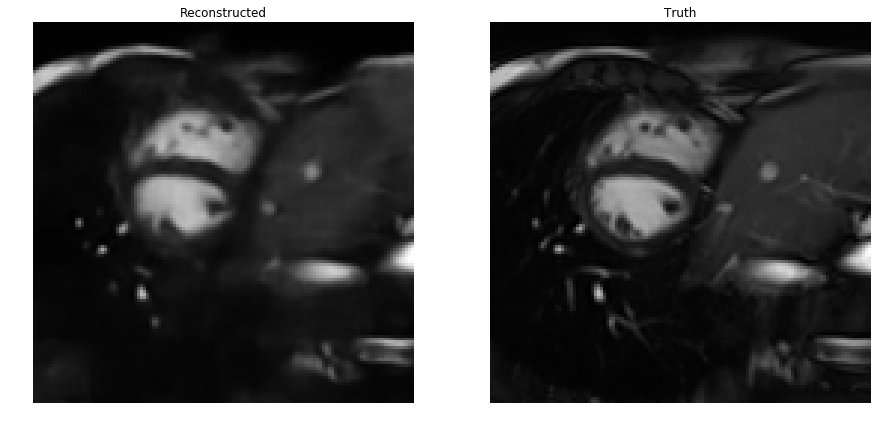

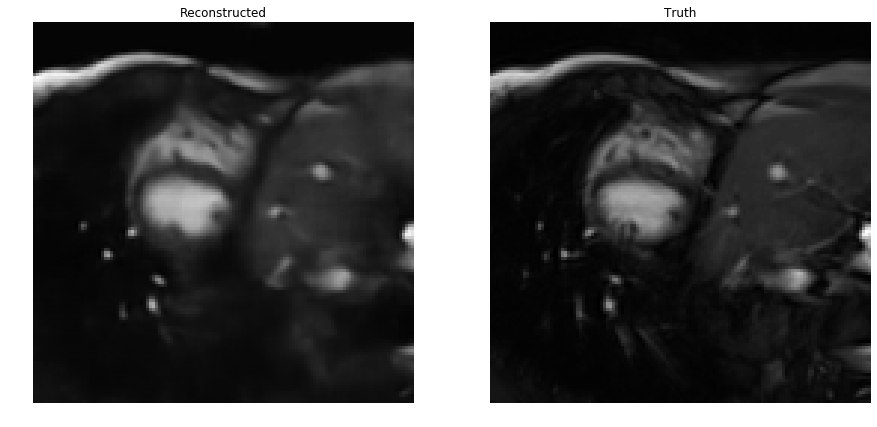

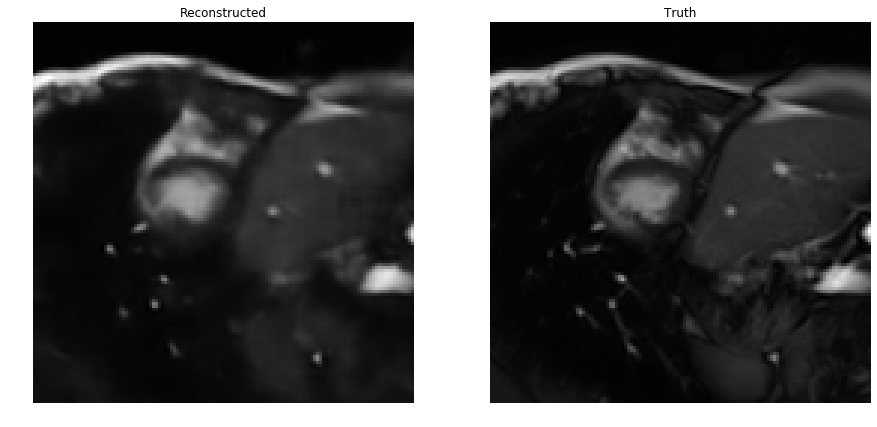

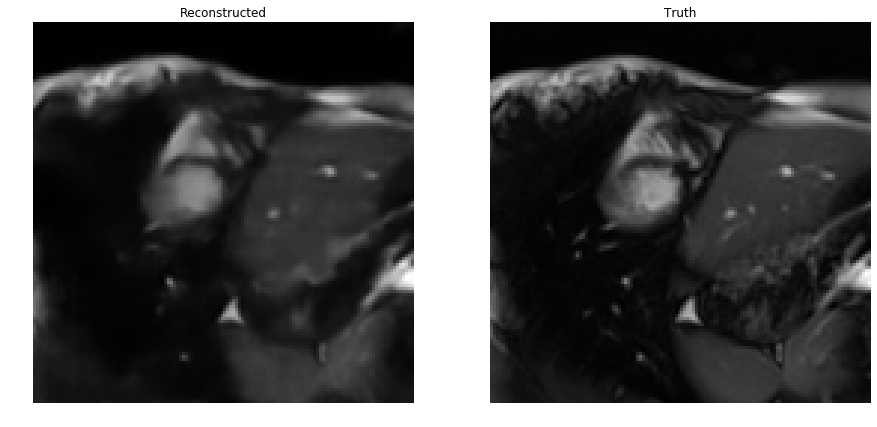

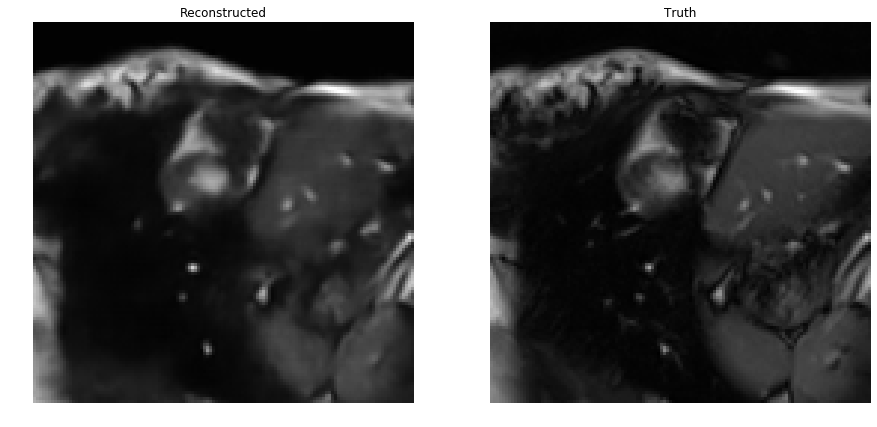

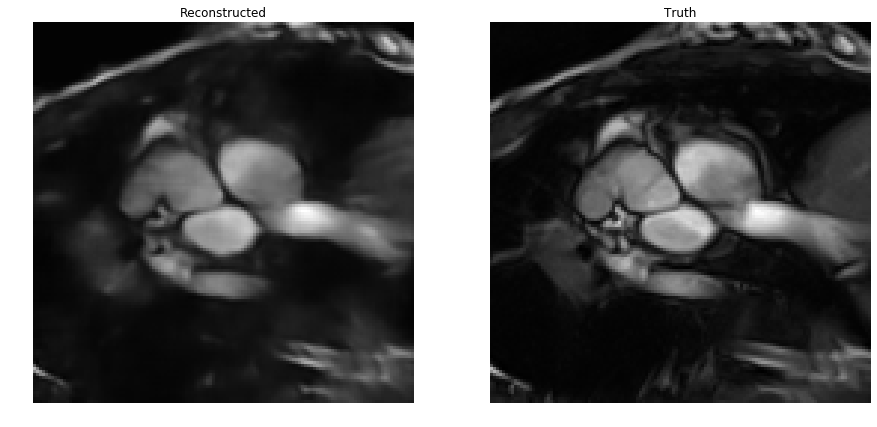

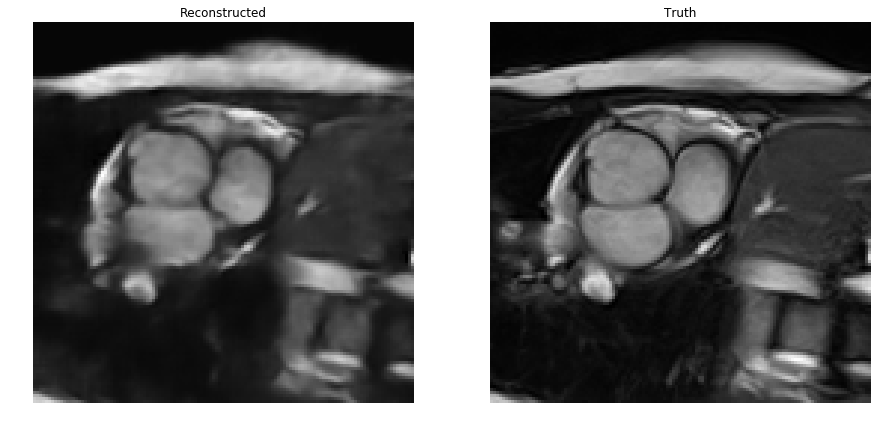

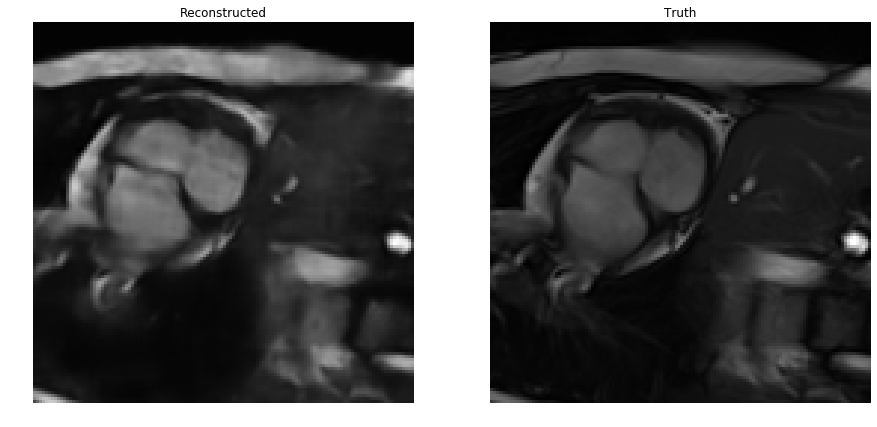

In [117]:
for k in range(10):
# Let's look at a smaple data again to check everything is the same
    f, arr = plt.subplots(1,2,figsize=(15,15))
    arr[0].imshow(result_vec[k][0,0,:,:,10], cmap='gray')
    arr[0].set_title("Reconstructed")
    arr[0].axis('off')
    arr[1].imshow(test_truth[k,0,:,:,10], cmap='gray')
    arr[1].set_title("Truth")
    arr[1].axis('off');

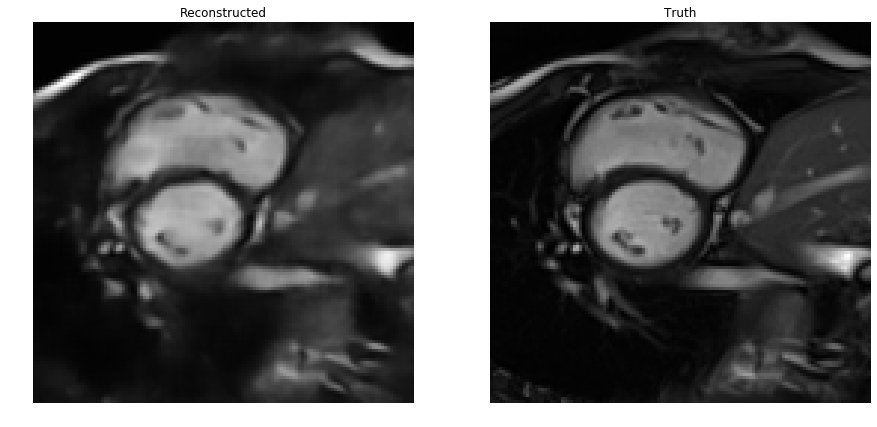

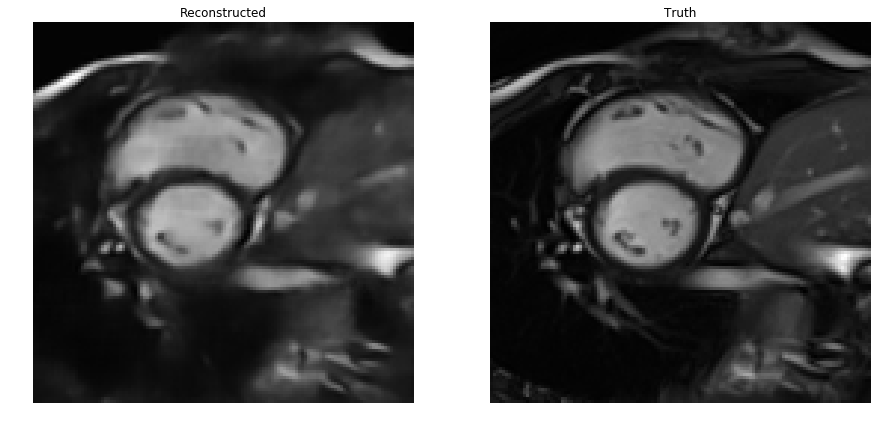

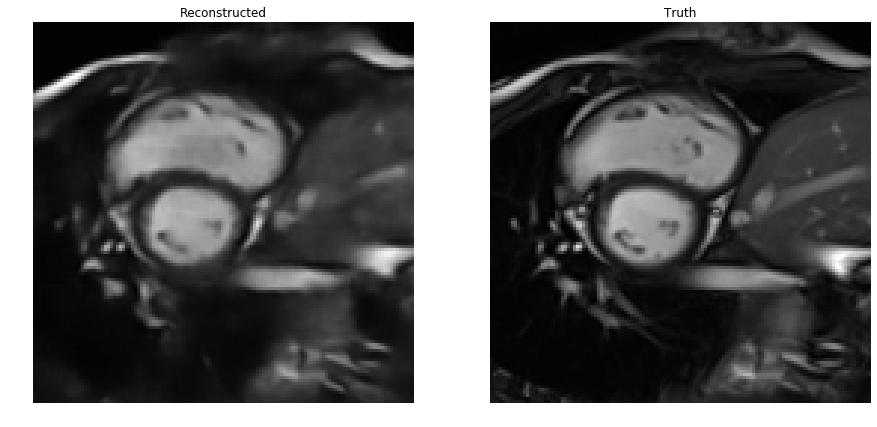

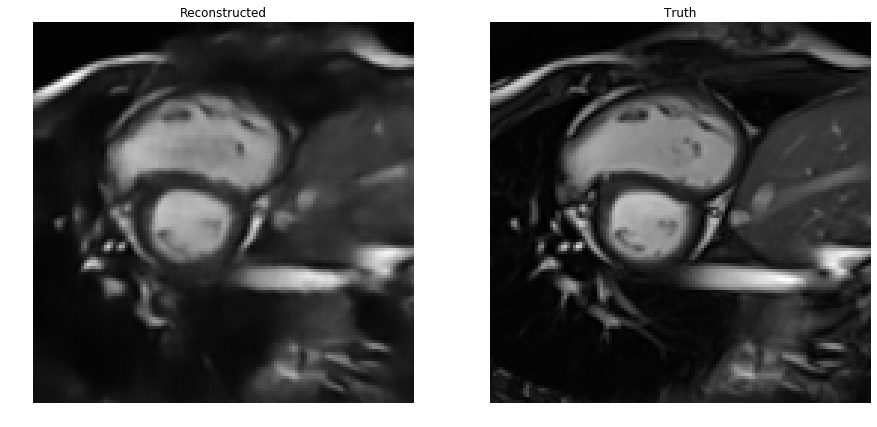

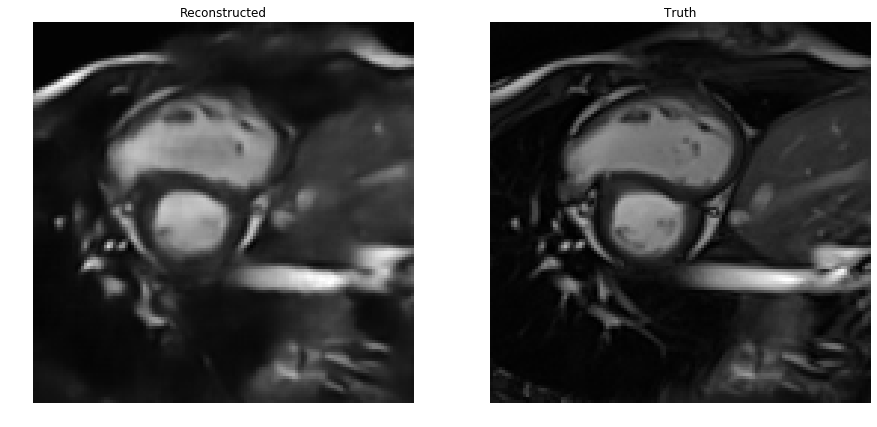

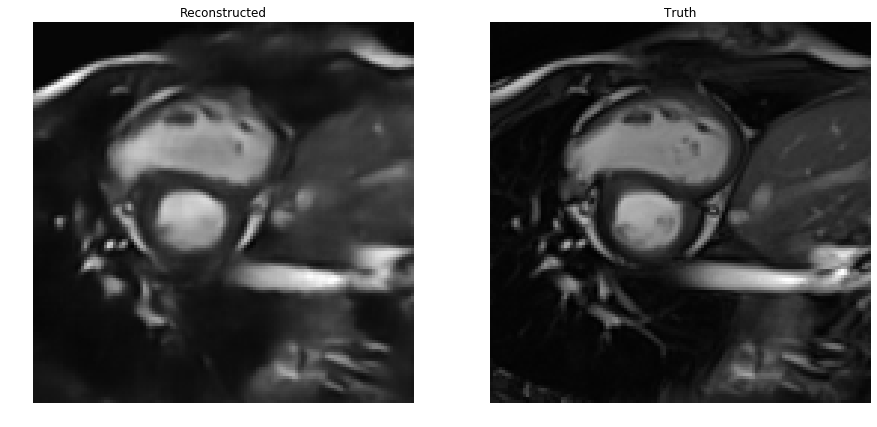

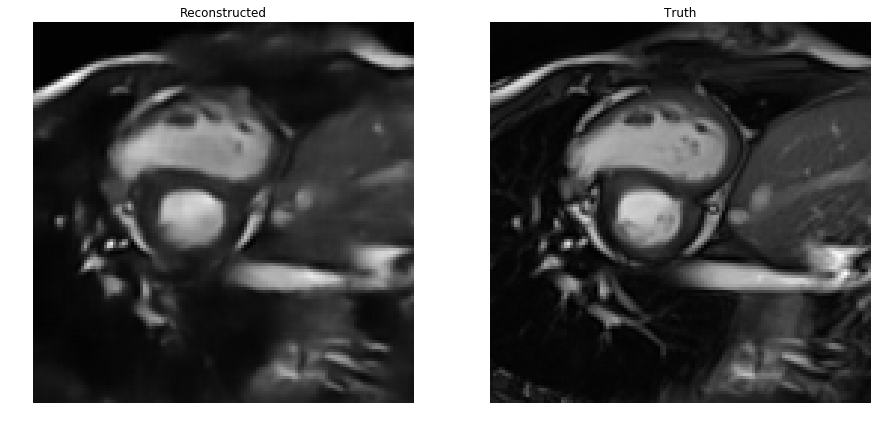

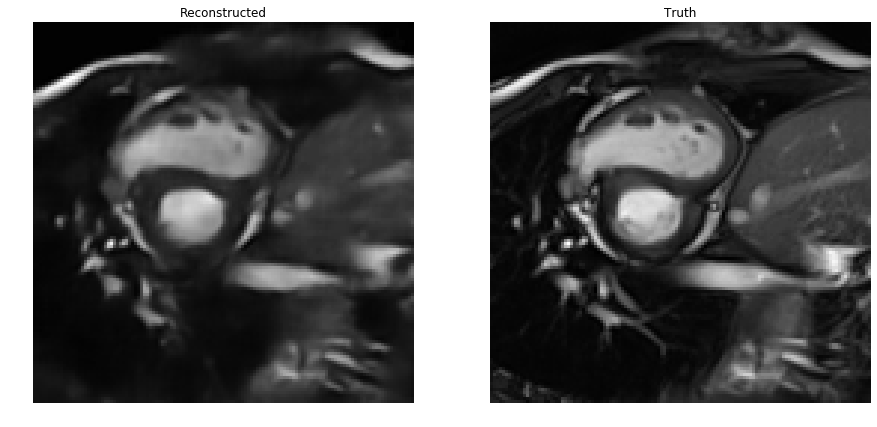

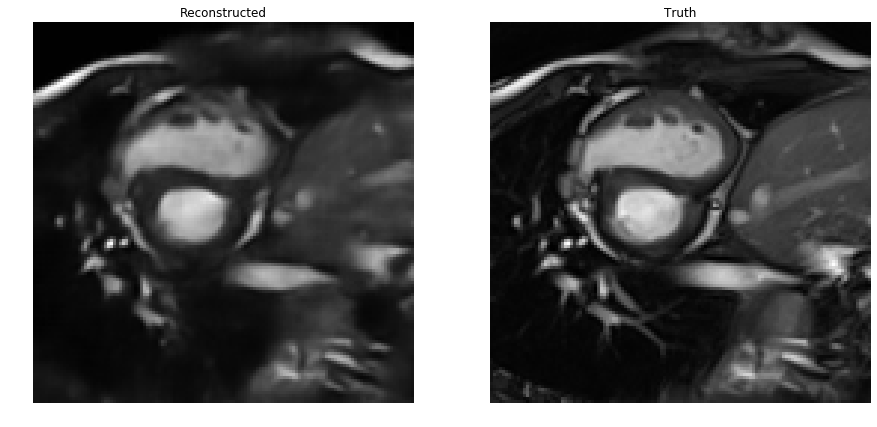

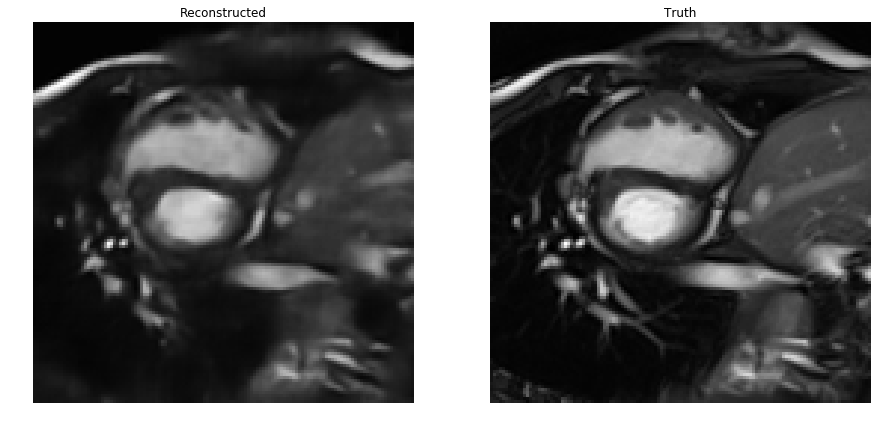

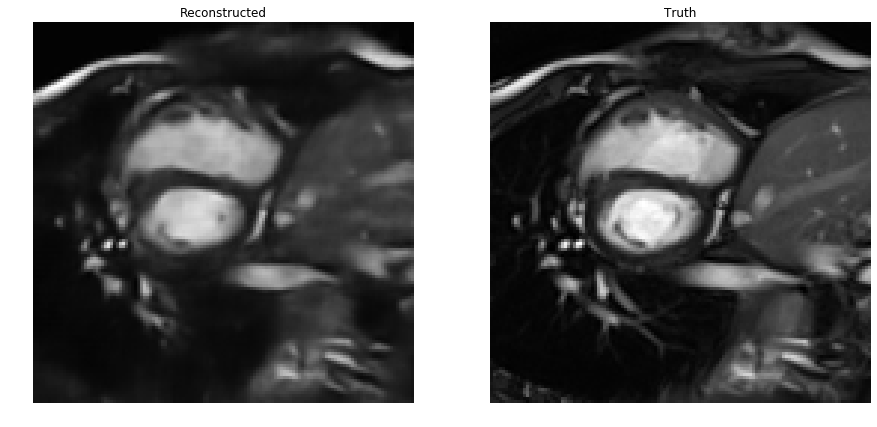

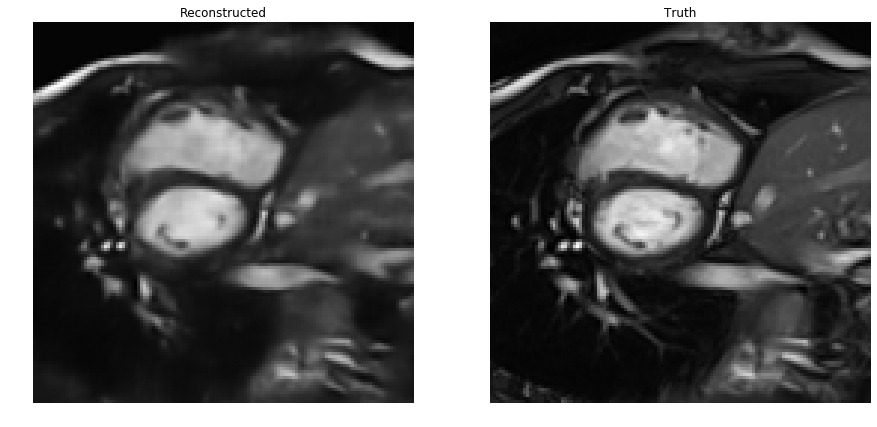

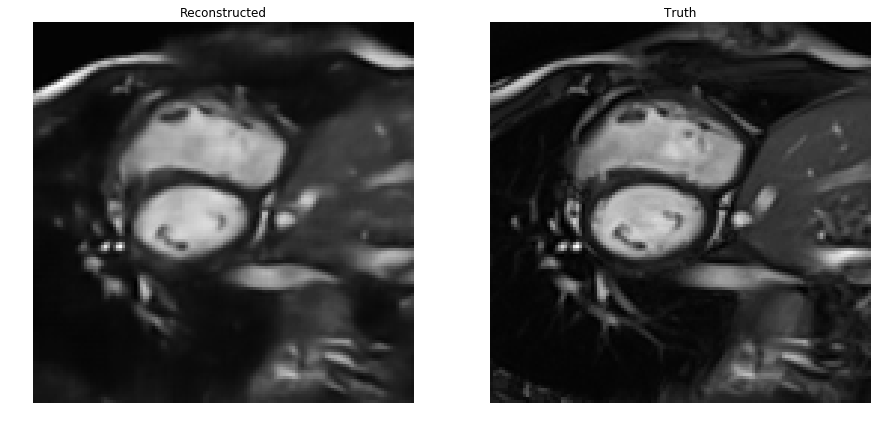

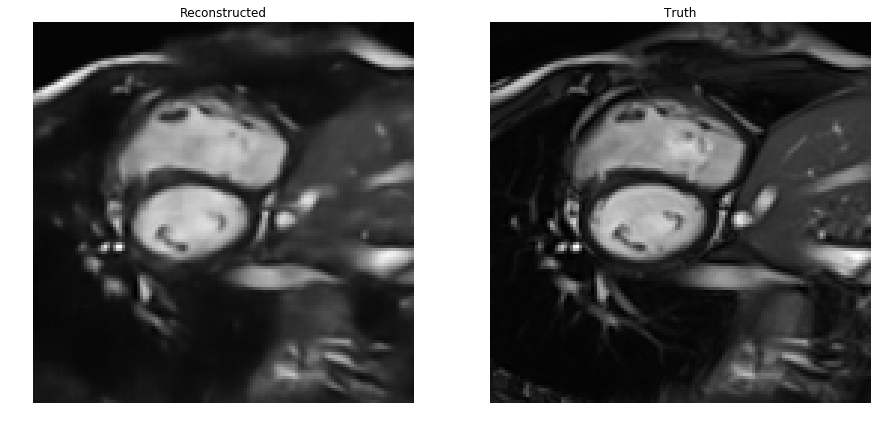

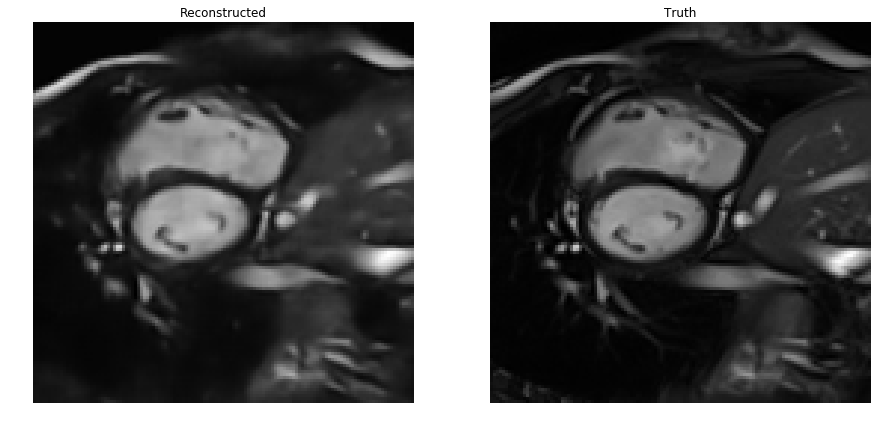

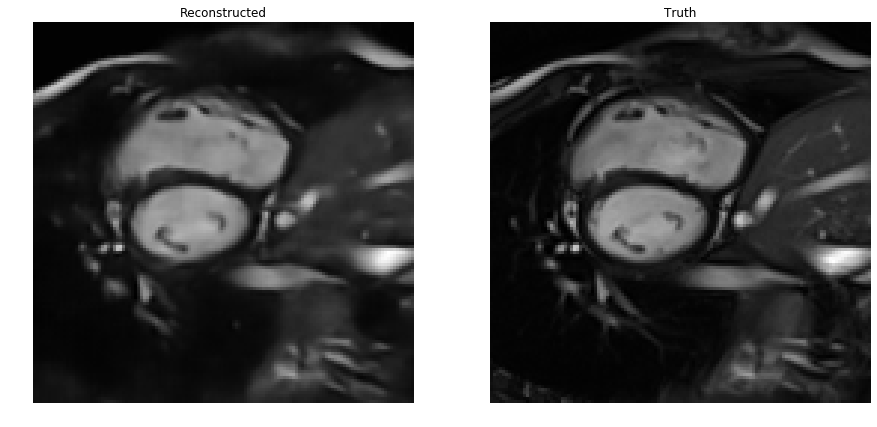

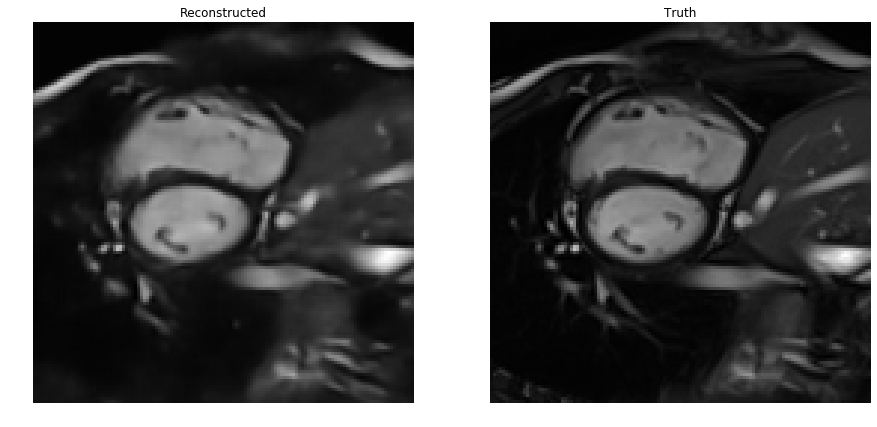

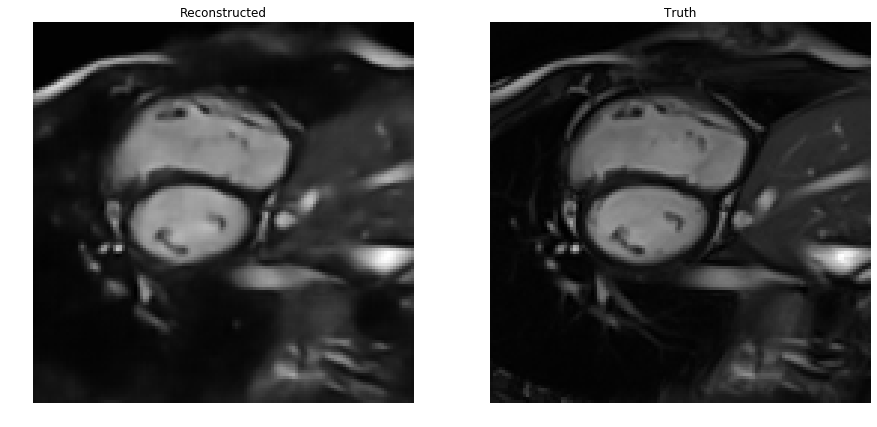

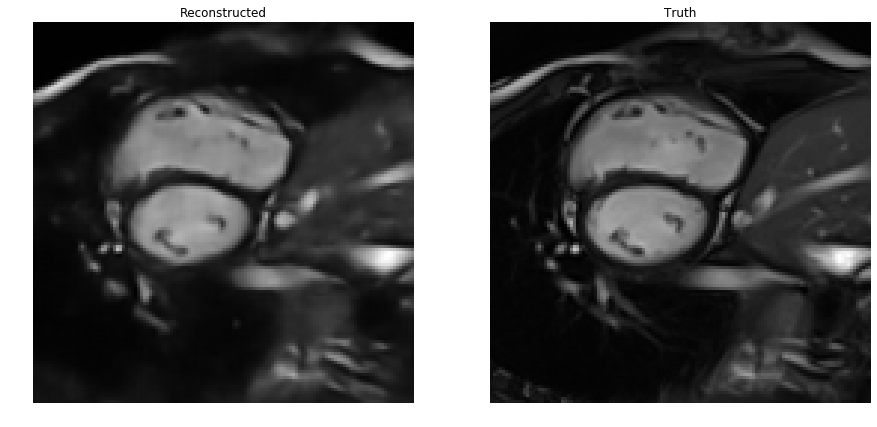

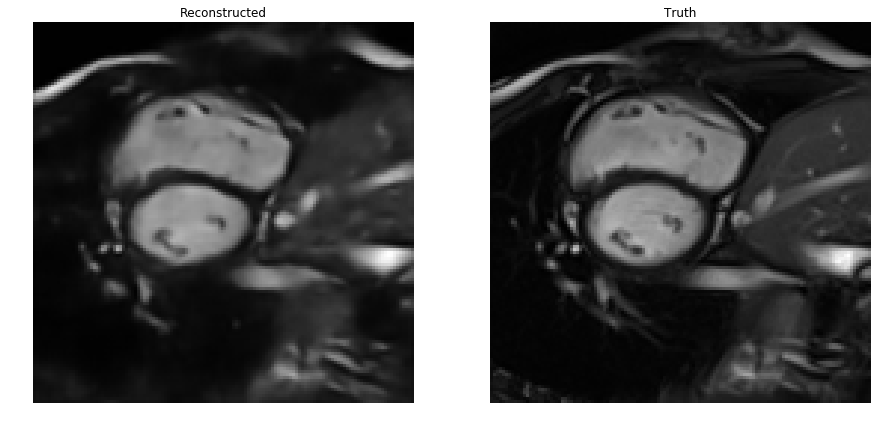

In [118]:
for k in range(20):
# Let's look at a smaple data again to check everything is the same
    f, arr = plt.subplots(1,2,figsize=(15,15))
    arr[0].imshow(result_vec[0][0,0,:,:,k], cmap='gray')
    arr[0].set_title("Reconstructed")
    arr[0].axis('off')
    arr[1].imshow(test_truth[0,0,:,:,k], cmap='gray')
    arr[1].set_title("Truth")
    arr[1].axis('off');